In [118]:
from load_data import *
from helpers import *
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR, LinearSVR
from sklearn.feature_selection import VarianceThreshold

In [119]:
price, listings, reviews = load_data()

/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:54: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  price = price.str.replace("$","")


Data loaded.


/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["host_location_country"][fil] = str(i)
/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:89: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  fil = listings["host_location"].str.contains(i, case = False, na = False)
/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["host_

Data cleansed.
Imputation done. No NaN's are left in the data.
Further Modifications are done.
Have fun implementing your models.


# Data format modification

We will ignore all text columns for now. So filter them out:

In [120]:
text_col = ["name", "host_name", "description", "neighborhood_overview", "host_about"]
listings = listings.drop(text_col, axis = 1)

Facing the NAs of the data, we observe that there are many missing values
Actually there shall not be any NA's left.

In [121]:
na_values = listings.isna().sum().sort_values()
na_values.where(na_values > 100).dropna()

Series([], dtype: float64)

In [124]:
na_filter = listings.isna().any(axis = 1)
listings = listings[~na_filter]
price = price[~na_filter]
listings = listings.reset_index(drop = True)
price= price.reset_index(drop = True)



In [125]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Variable Selection

In [127]:
price_y = price["log_price"]

In [128]:
num_col = ['host_since', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'beds', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month', "counts", "brightness"]


binary_col = ['Bathtub', 'Bed linens', 'Breakfast',
       'Cleaning before checkout', 'Dishwasher', 'Elevator', 'Hair dryer',
       'Indoor fireplace', 'Long term stays allowed', 'Private entrance',
       'Security cameras on property', 'Single level home', 'Oven_available',
       'Stoves_available', 'Refridgerator_available',
       'Body_soap_available', 'Garden_backyard_available',  'Children_Entertainment', 'Workspace',
       'Shampoo_Conditioner_available', 'Fast_wifi_available',
       'Gym_available', 'Coffee_machine_available', 'Dryer_available',
       'Washer_available', 'Hot_tub_available', 'Pool_available',
       'Patio_balcony_available', 'Wifi_available', 'AC_available',
       'heating_available', 'Kitchen_available', 'Safe_available',
       'Water_location','neighbourhood_cleansed_Dn Laoghaire-Rathdown',
       'neighbourhood_cleansed_Dublin City',
       'neighbourhood_cleansed_Fingal',
       'neighbourhood_cleansed_South Dublin',
       'property_type_Entire bungalow', 'property_type_Entire cabin',
       'property_type_Entire condominium (condo)',
       'property_type_Entire cottage', 'property_type_Entire guest suite',
       'property_type_Entire guesthouse', 'property_type_Entire loft',
       'property_type_Entire rental unit',
       'property_type_Entire residential home',
       'property_type_Entire serviced apartment',
       'property_type_Entire townhouse', 'property_type_Others',
       'property_type_Private room',
       'property_type_Private room in bed and breakfast',
       'property_type_Private room in bungalow',
       'property_type_Private room in cabin',
       'property_type_Private room in condominium (condo)',
       'property_type_Private room in cottage',
       'property_type_Private room in guest suite',
       'property_type_Private room in guesthouse',
       'property_type_Private room in rental unit',
       'property_type_Private room in residential home',
       'property_type_Private room in townhouse',
       'property_type_Tiny house', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room',
       'host_location_country_Argentina',
       'host_location_country_Australia', 'host_location_country_Belgium',
       'host_location_country_Brazil', 'host_location_country_Bulgaria',
       'host_location_country_Canada', 'host_location_country_Croatia',
       'host_location_country_France', 'host_location_country_Germany',
       'host_location_country_India', 'host_location_country_Ireland',
       'host_location_country_Israel', 'host_location_country_Italy',
       'host_location_country_Mexico',
       'host_location_country_Netherlands',
       'host_location_country_Others', 'host_location_country_Poland',
       'host_location_country_Portugal', 'host_location_country_Spain',
       'host_location_country_Sweden',
       'host_location_country_Switzerland',
       'host_location_country_Turkey',
       'host_location_country_United Kingdom',
       'host_location_country_United States', 'bath_kind_Normal',
       'bath_kind_Private', 'bath_kind_Shared', "TV_available", "sound_system_available",
       'Free_parking', 'Paid_parking', 'Special_stuff', 'Outdoor_stuff',
       'Baby_friendly', 'bath_number_0', 'bath_number_1', 'bath_number_2', 'bath_number_3',
       'bath_number_greater3', 'bedroom_number_1', 'bedroom_number_2', 'bedroom_number_3',
       'bedroom_number_greater3', "Game_consoles"]


In [129]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(listings[num_col])
stand_values = scaler.transform(listings[num_col])
listings[num_col] = stand_values


## Random Forest Model

In [130]:
# train full random forest
forest = RandomForestRegressor(1000, random_state = 123, max_features = "sqrt", max_depth = 7)
X_train, X_test, y_train, y_test = train_test_split(listings, price_y, random_state = 123)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.4002236869587832

## Naive approach with training data

Compute the importance of each feature which is basically the average contribution to the decrease in impurity/MSE. Let's also consider the standard deviation of this contribution.

In [24]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=listings.columns)

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_11030/1908474449.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


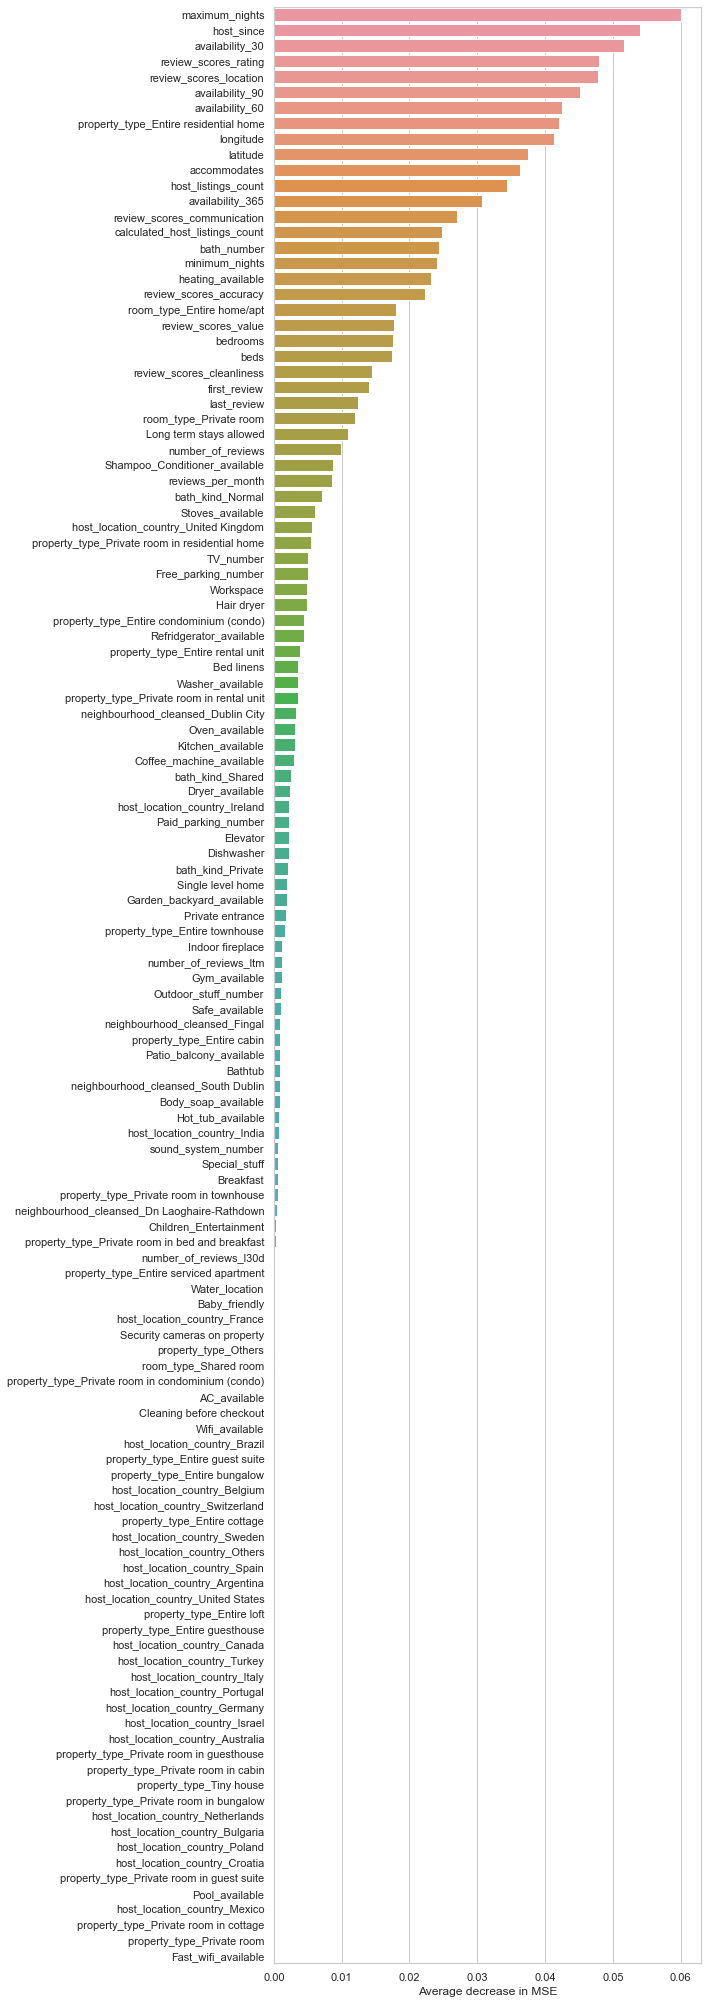

In [25]:
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Average decrease in MSE")
fig.tight_layout()
fig.show()

The blue bars of the diagram indicate by how much the impurity was decreased on average when using the feature in a tree. The black lines give the standard deviation
Problem of the importance measure: We only consider the training data and how important each feature is on average for the training model. 

Therefore we also use another approach. We take the test data and shuffle a feature randomly and evaluate the mode score. Thereby we cut the connection between target and feature. If the model accuracy/MSE decreases significantly the feature might be important for the prediction.

### Permutation approach

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_11030/1120045921.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


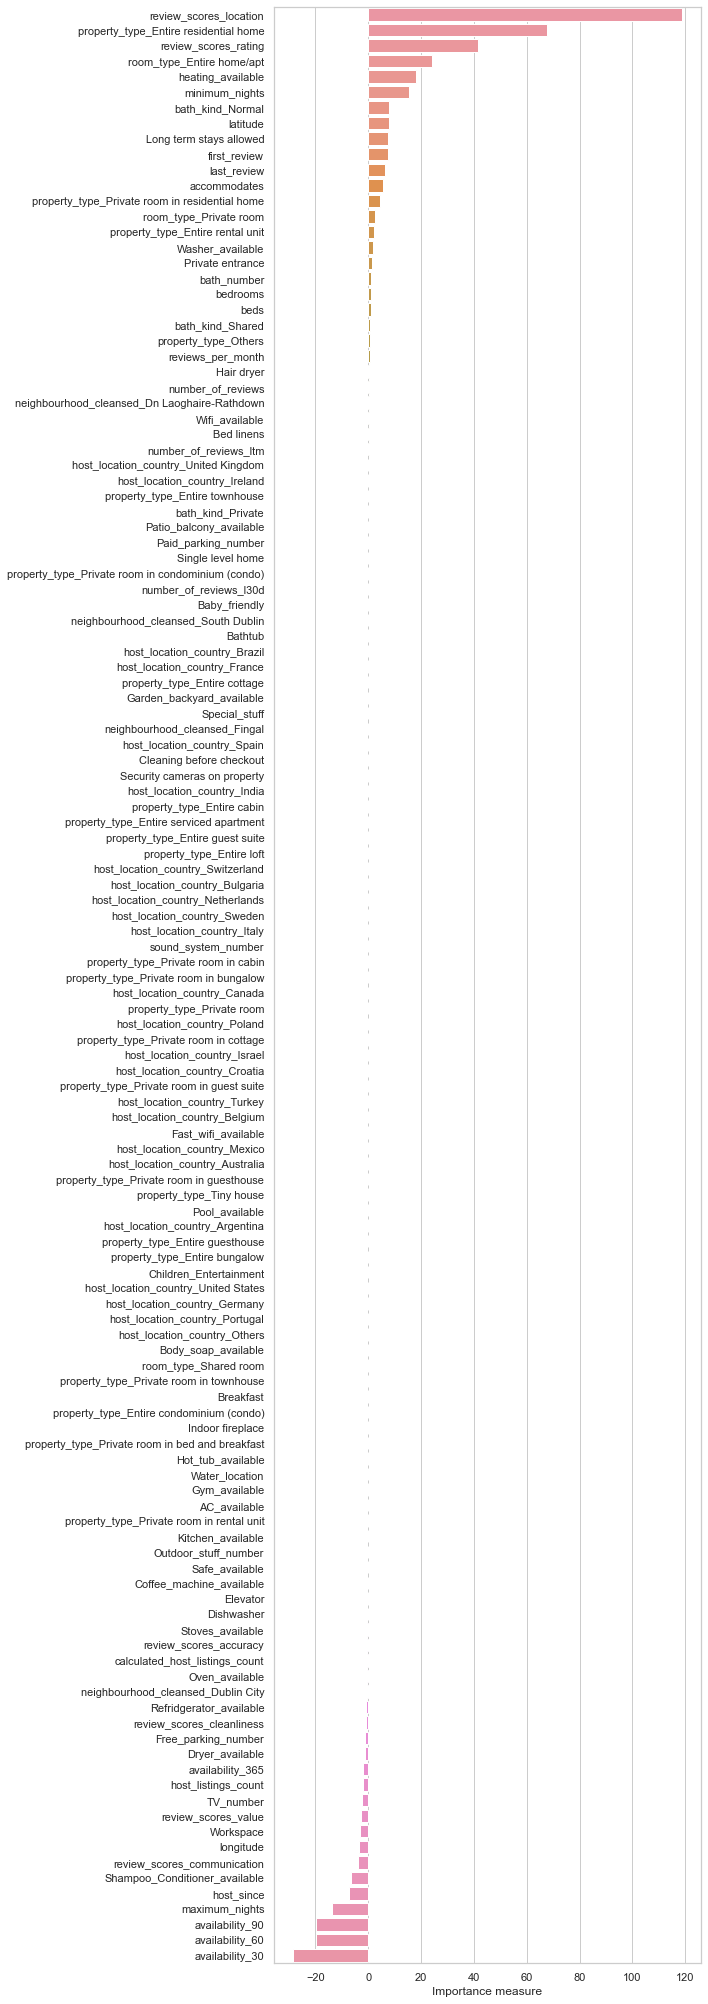

In [26]:
result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42)
forest_importances = pd.Series(result.importances_mean, index=listings.columns)
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## Ridge with Kernel model
Let's repeat the permutation approach for several other algorithms

### rbf kernel

In [64]:
# train Ridge Kernel model
rbf_ridge = KernelRidge(kernel = "rbf", alpha = 0)
rbf_ridge.fit(X_train, y_train)
rbf_ridge.score(X_test, y_test)

-28.947508003116944

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_3738/1598192241.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


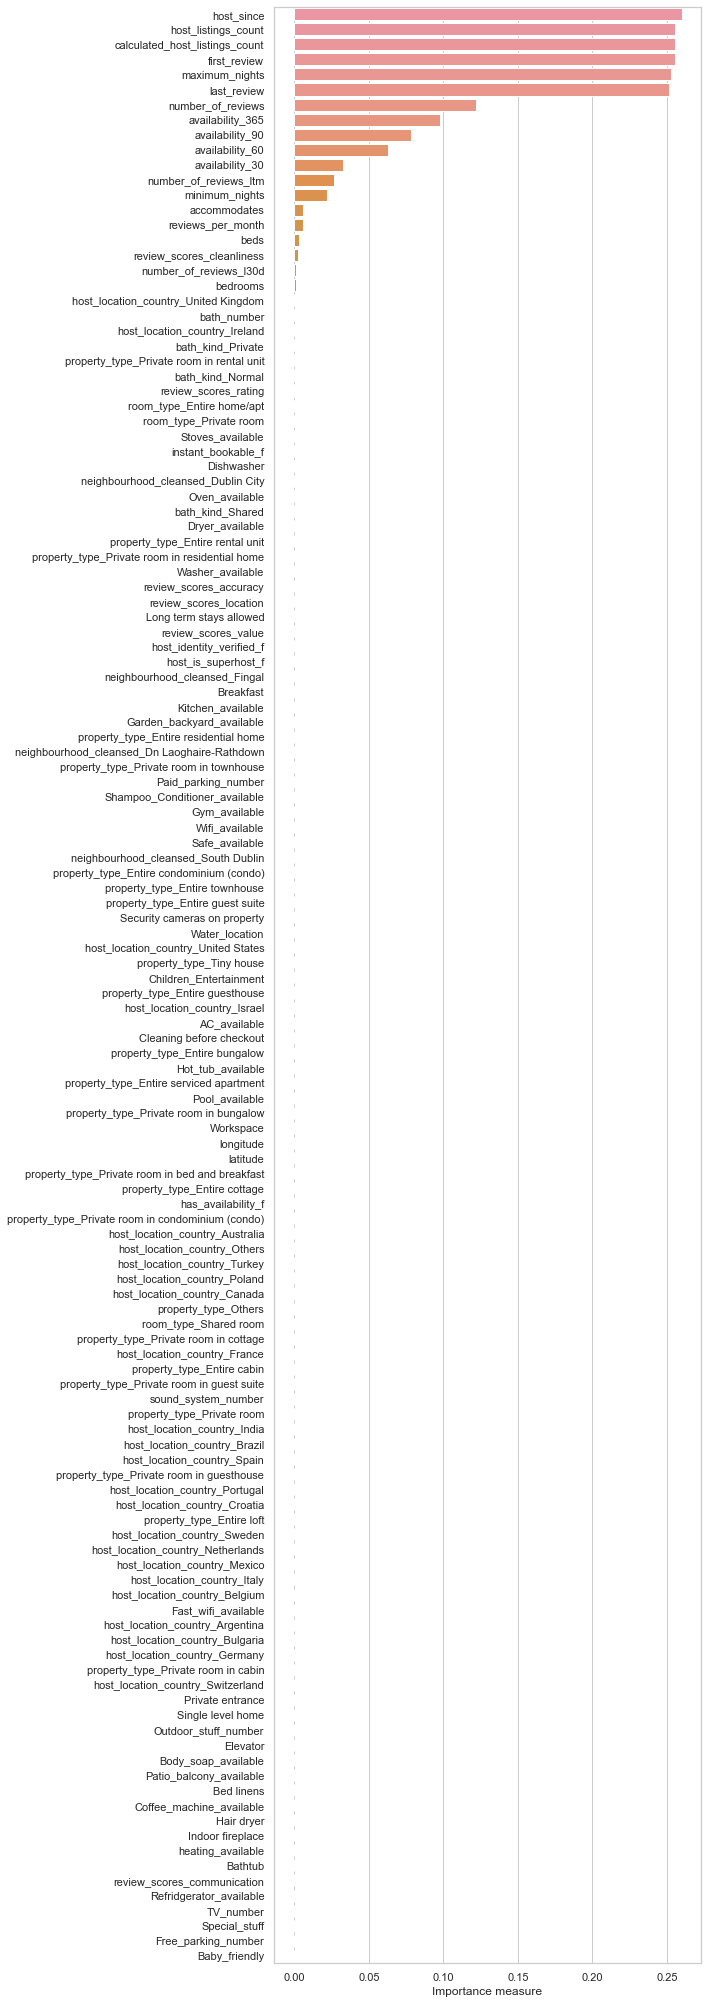

In [27]:
result = permutation_importance(rbf_ridge, X_test, y_test, n_repeats=10, random_state=42)
rbf_ridge_importances = pd.Series(result.importances_mean, index=listings.columns)
# sort the features by their importance
plot_data = rbf_ridge_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

### linear kernel

In [84]:
# train Ridge Kernel model
linear_ridge = KernelRidge(kernel = "linear")
linear_ridge.fit(X_train, y_train)
linear_ridge.score(X_test, y_test)

-35.59898229706792

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_11030/3969062155.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


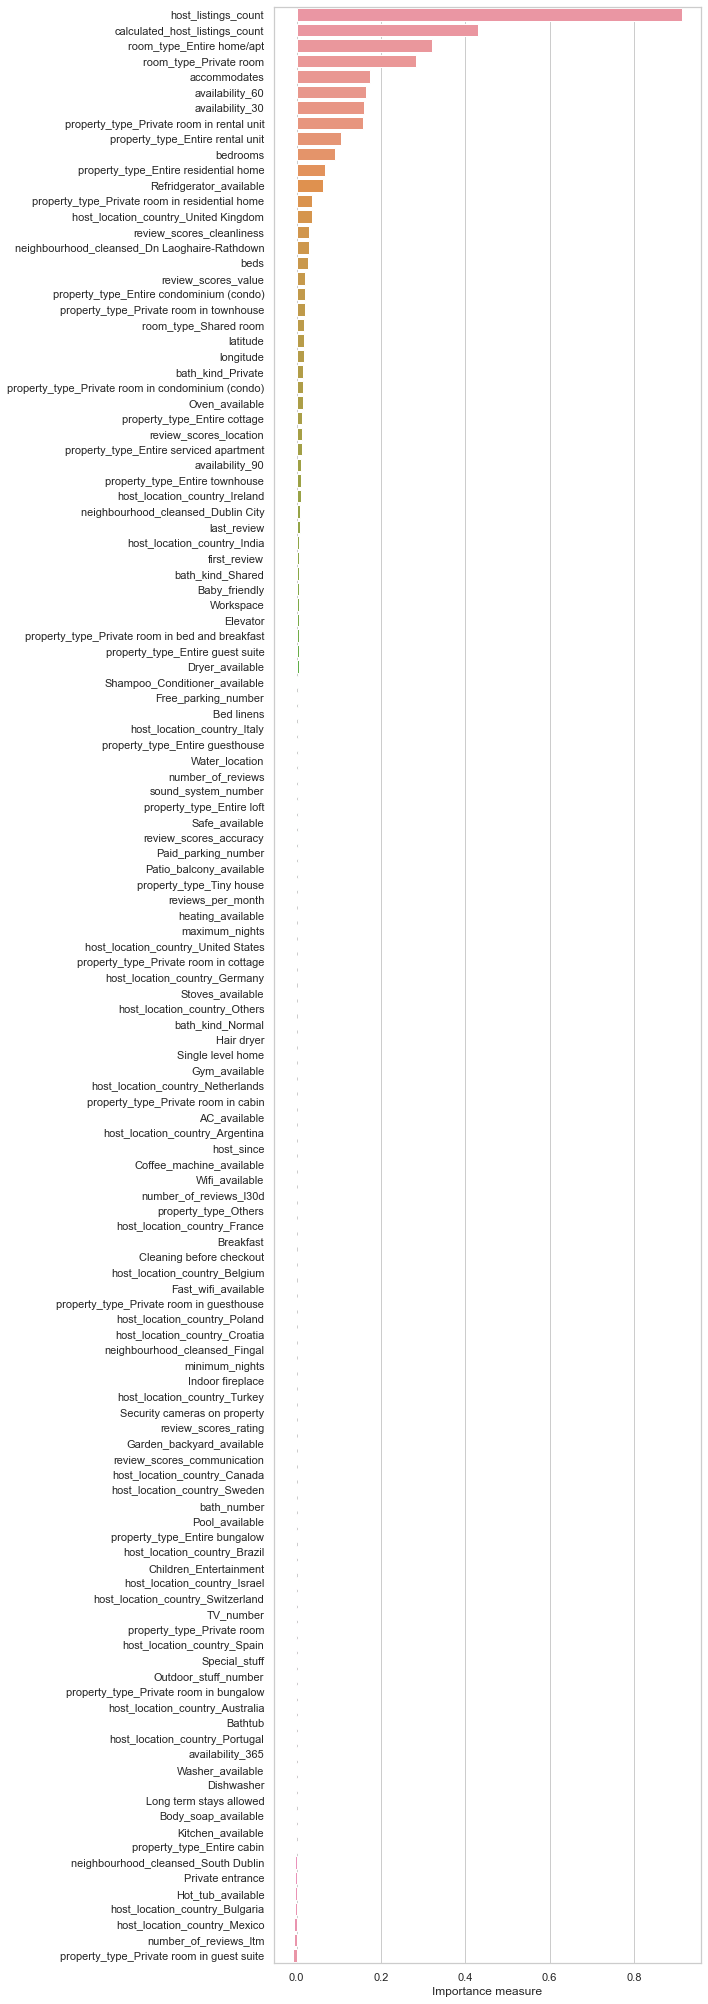

In [85]:
result = permutation_importance(linear_ridge, X_test, y_test, n_repeats=10, random_state=42)
linear_ridge_importances = pd.Series(result.importances_mean, index=listings.columns)
# sort the features by their importance
plot_data = linear_ridge_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## SVR
### rbf kernel

In [31]:
# train Ridge Kernel model
rbf_svr= SVR(kernel = "rbf")
rbf_svr.fit(X_train, y_train)
rbf_svr.score(X_test, y_test)

-0.041718898912411095

In [31]:
#result = permutation_importance(rbf_svr, X_test, y_test, n_repeats=10, random_state=42, scoring = "r2")
#rbf_svr_importances = pd.Series(result.importances_mean, index=listings.columns)
# sort the features by their importance
#plot_data = rbf_svr_importances.sort_values(ascending=False)

# plotting
#sn.set_theme(style = "whitegrid")
#fig, ax = plt.subplots(figsize = (10,28))
#sn.barplot(x=plot_data.values, y=plot_data.index)
#ax.set_xlabel("Importance measure")
#fig.tight_layout()
#fig.show()

In [29]:
# train Ridge Kernel model
linear_svr= LinearSVR(max_iter = 100000)
linear_svr.fit(X_train, y_train)
linear_svr.score(X_test, y_test)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.06431278932492579

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_3738/827178593.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


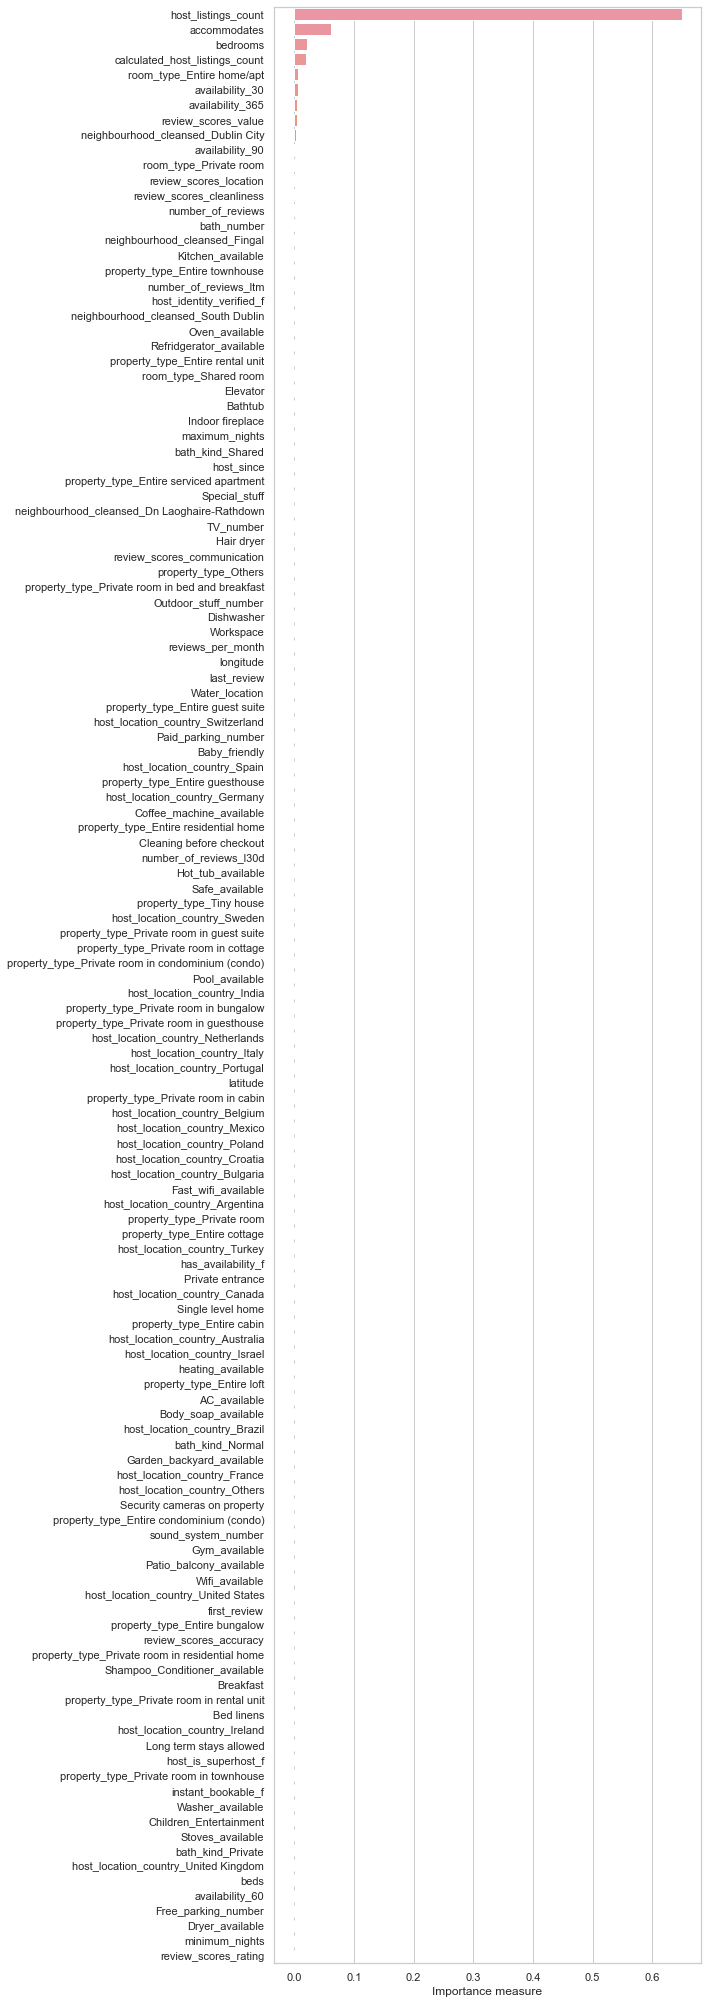

In [33]:
result = permutation_importance(linear_svr, X_test, y_test, n_repeats=10, random_state=42, scoring = "r2")
linear_svr_importances = pd.Series(result.importances_mean, index=listings.columns)
# sort the features by their importance
plot_data = linear_svr_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## Boosting

In [131]:
params = {
    "n_estimators": 200,
    "max_depth": 2,
    "min_samples_split": 10,
    "learning_rate": 0.1,
    "loss": "squared_error",
}

In [132]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.5206038324967012

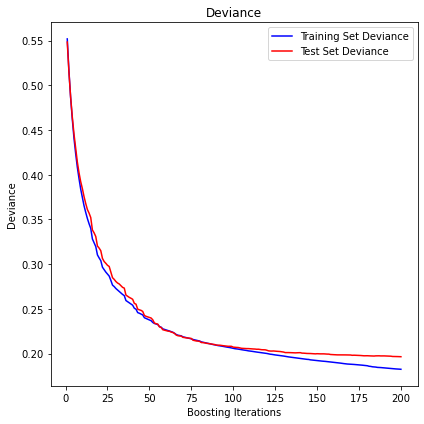

In [70]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

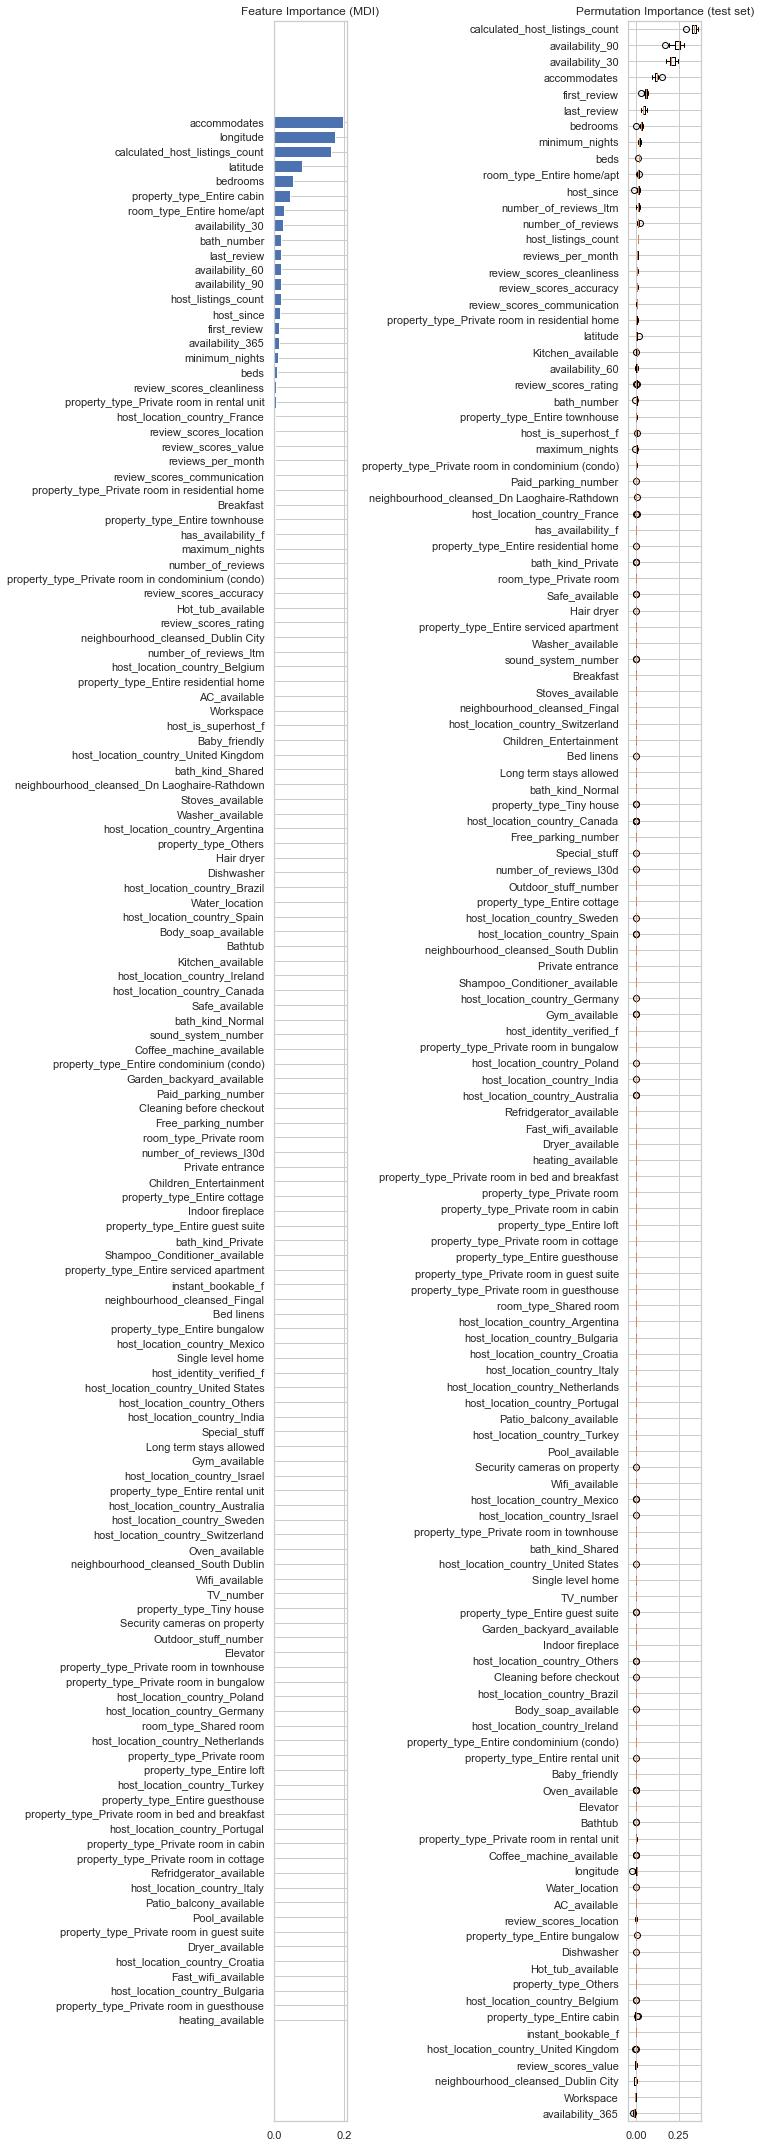

In [37]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(10, 30))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(listings.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(listings.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

The problem of this method is that the importance of highly correlated amenities disappears as shuffling the first feature the model could still get the information by the second correlated feature. 
This can be the case for our data. For instance the possibility to stay for a longer time might be highly correlated with the availability of a washing machine or having a kitchen and an oven.

# Correlation approach
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

We should take the correlation of the variables into account. Therefore we need different approaches dependent on the scale of variables
- pearson: numeric and numeric 
- jaccard: binary and binary
- point-biserial: binary and numeric

In [133]:
listings.columns.values

array(['host_since', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'beds', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month', 'Bathtub',
       'Bed linens', 'Breakfast', 'Cleaning before checkout',
       'Dishwasher', 'Elevator', 'Hair dryer', 'Indoor fireplace',
       'Long term stays allowed', 'Private entrance',
       'Security cameras on property', 'Single level home',
       'Oven_available', 'Stoves_available', 'Refridgerator_available',
       'Body_soap_available', 'Garden_backyard_available', 'Free_parking',
       'Paid_parking

In [134]:
# sanity check
len(num_col + binary_col) == len(listings.columns)

True

## Pearson Correlation

In [135]:
numerical_df = listings.filter(num_col)

sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
sel.feature_names_in_ = numerical_df.columns

sel.fit_transform(numerical_df)
num_col = sel.get_feature_names_out()
print(str(len(numerical_df.columns) - len(num_col)) + " variables have been removed")
numerical_df = numerical_df.filter(num_col)

0 variables have been removed


In [136]:
PEARSON = np.abs(numerical_df.corr())

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_31964/605140178.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(im)


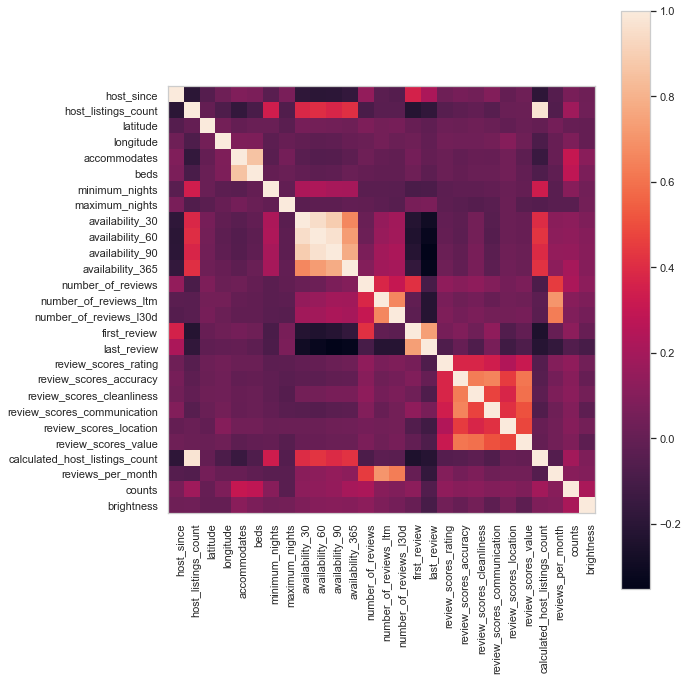

In [137]:
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(listings.filter(num_col).corr())
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(num_col)), labels=num_col)
ax.set_yticks(np.arange(len(num_col)), labels=num_col)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.tight_layout()
plt.show()

## Binary Features

Let's remove features which don't have enough variance or in other words which are either 0 or 1 in most of the cases 
- https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
- https://towardsdatascience.com/how-to-use-variance-thresholding-for-robust-feature-selection-a4503f2b5c3f







In [138]:
from sklearn.feature_selection import VarianceThreshold


In [139]:
binary_df = listings.filter(binary_col)

sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
sel.feature_names_in_ = binary_df.columns

sel.fit_transform(binary_df)
binary_col = sel.get_feature_names_out()
print(str(len(binary_df.columns) - len(binary_col)) + " variables have been removed")
binary_df = binary_df.filter(binary_col)

68 variables have been removed


### Jaccard Correlation

At first lets define a function that calculates the Jaccard Correlation coefficient

In [140]:
def jac(x,y):
    a = ((x == 1) == (y == 1)).sum()
    b = ((x == 1) == (y == 0)).sum()
    c = ((x == 0) == (y == 1)).sum()
    #d = ((x == 0) == (y == 0)).sum()

    j = a/(a+b+c)

    return j

Now calculate the coefficient for each combination of binary covariables

In [141]:
# init matrix
A = np.zeros((len(binary_col), len(binary_col)))

for i, a in enumerate(binary_col):
    for j, b in enumerate(binary_col):
        A[i,j] = jac(binary_df[a], binary_df[b])


/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_31964/2473703125.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(im)


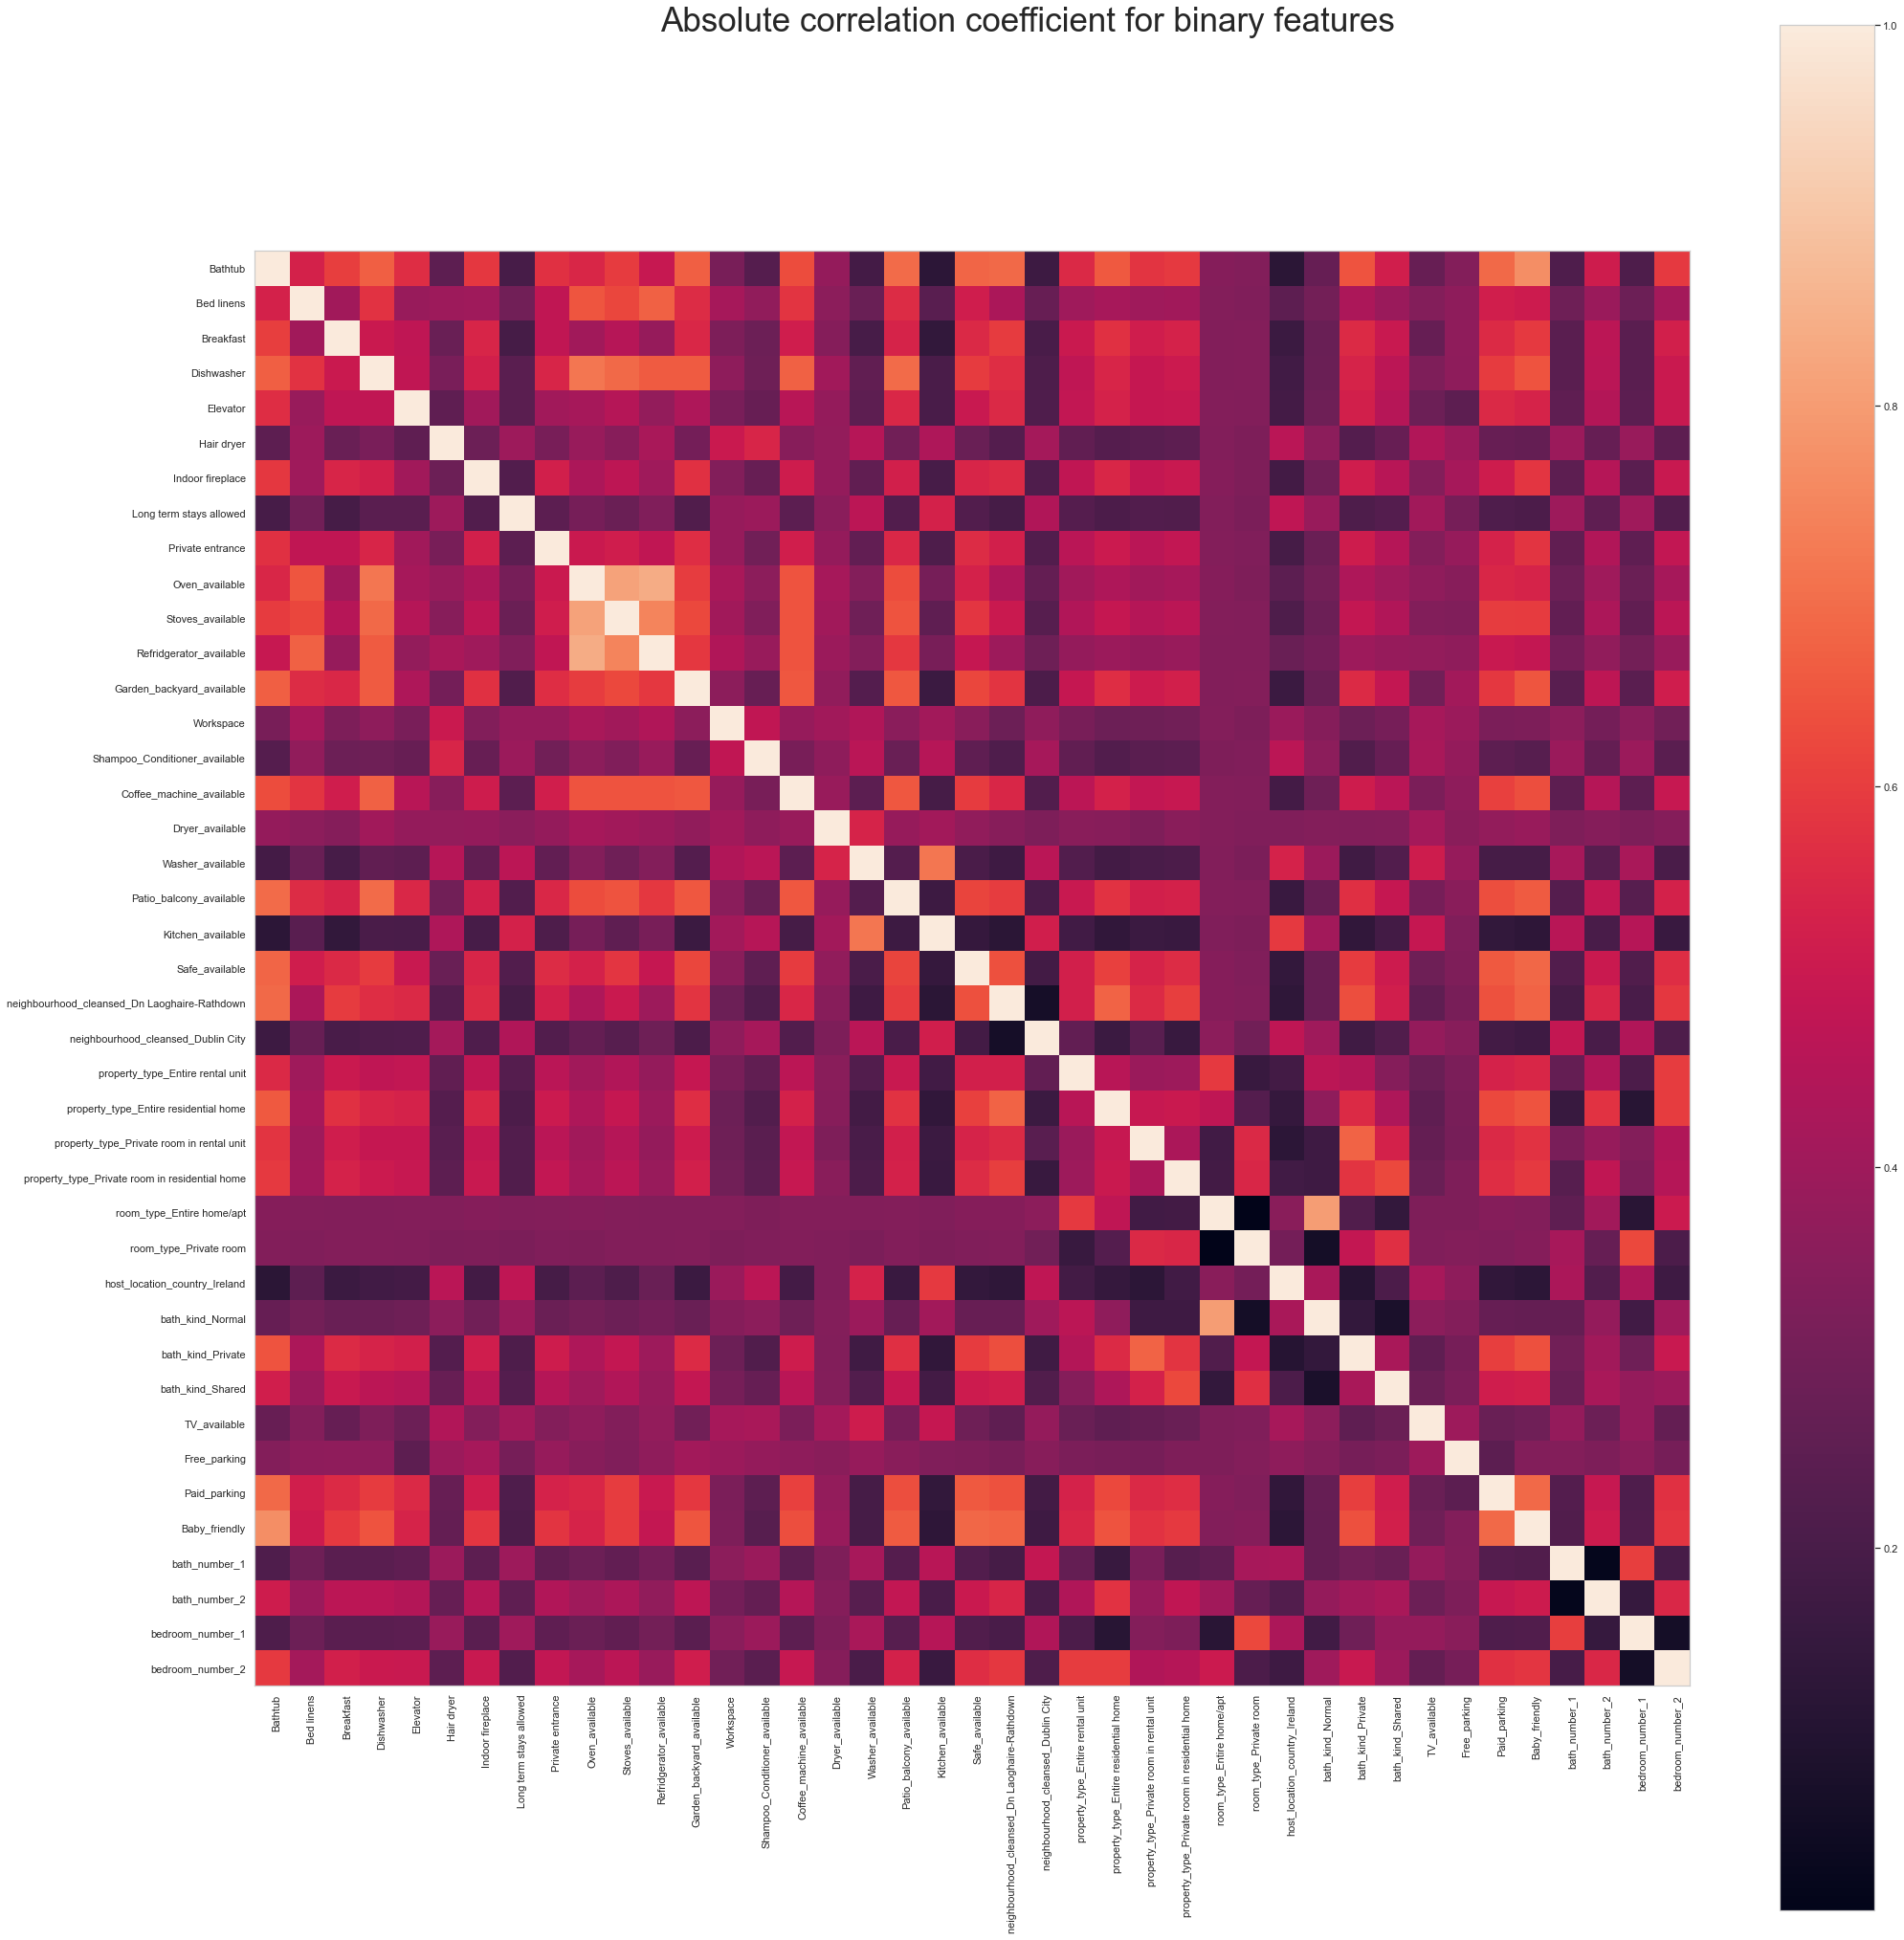

In [142]:
JACCARD = pd.DataFrame(np.abs(A))
jac_df = pd.DataFrame(np.abs(A))

fig, ax = plt.subplots(figsize = (30,30))
im = ax.imshow(jac_df)
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(binary_col)), labels=binary_col)
ax.set_yticks(np.arange(len(binary_col)), labels=binary_col)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.suptitle("Absolute correlation coefficient for binary features", fontsize = 35)
fig.tight_layout()
plt.show()

## Point-Biserial

- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pointbiserialr.html

In [143]:
from scipy import stats
binaries = binary_df
numericals = numerical_df

# init matrix
A = np.zeros((len(binaries.columns), len(numericals.columns)))
P = np.zeros((len(binaries.columns), len(numericals.columns)))

for i, a in enumerate(binaries.columns):
    for j, b in enumerate(numericals.columns):
        A[i,j], P[i,j] = stats.pointbiserialr(binaries[a], numericals[b])

    


/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_31964/357590416.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(im)


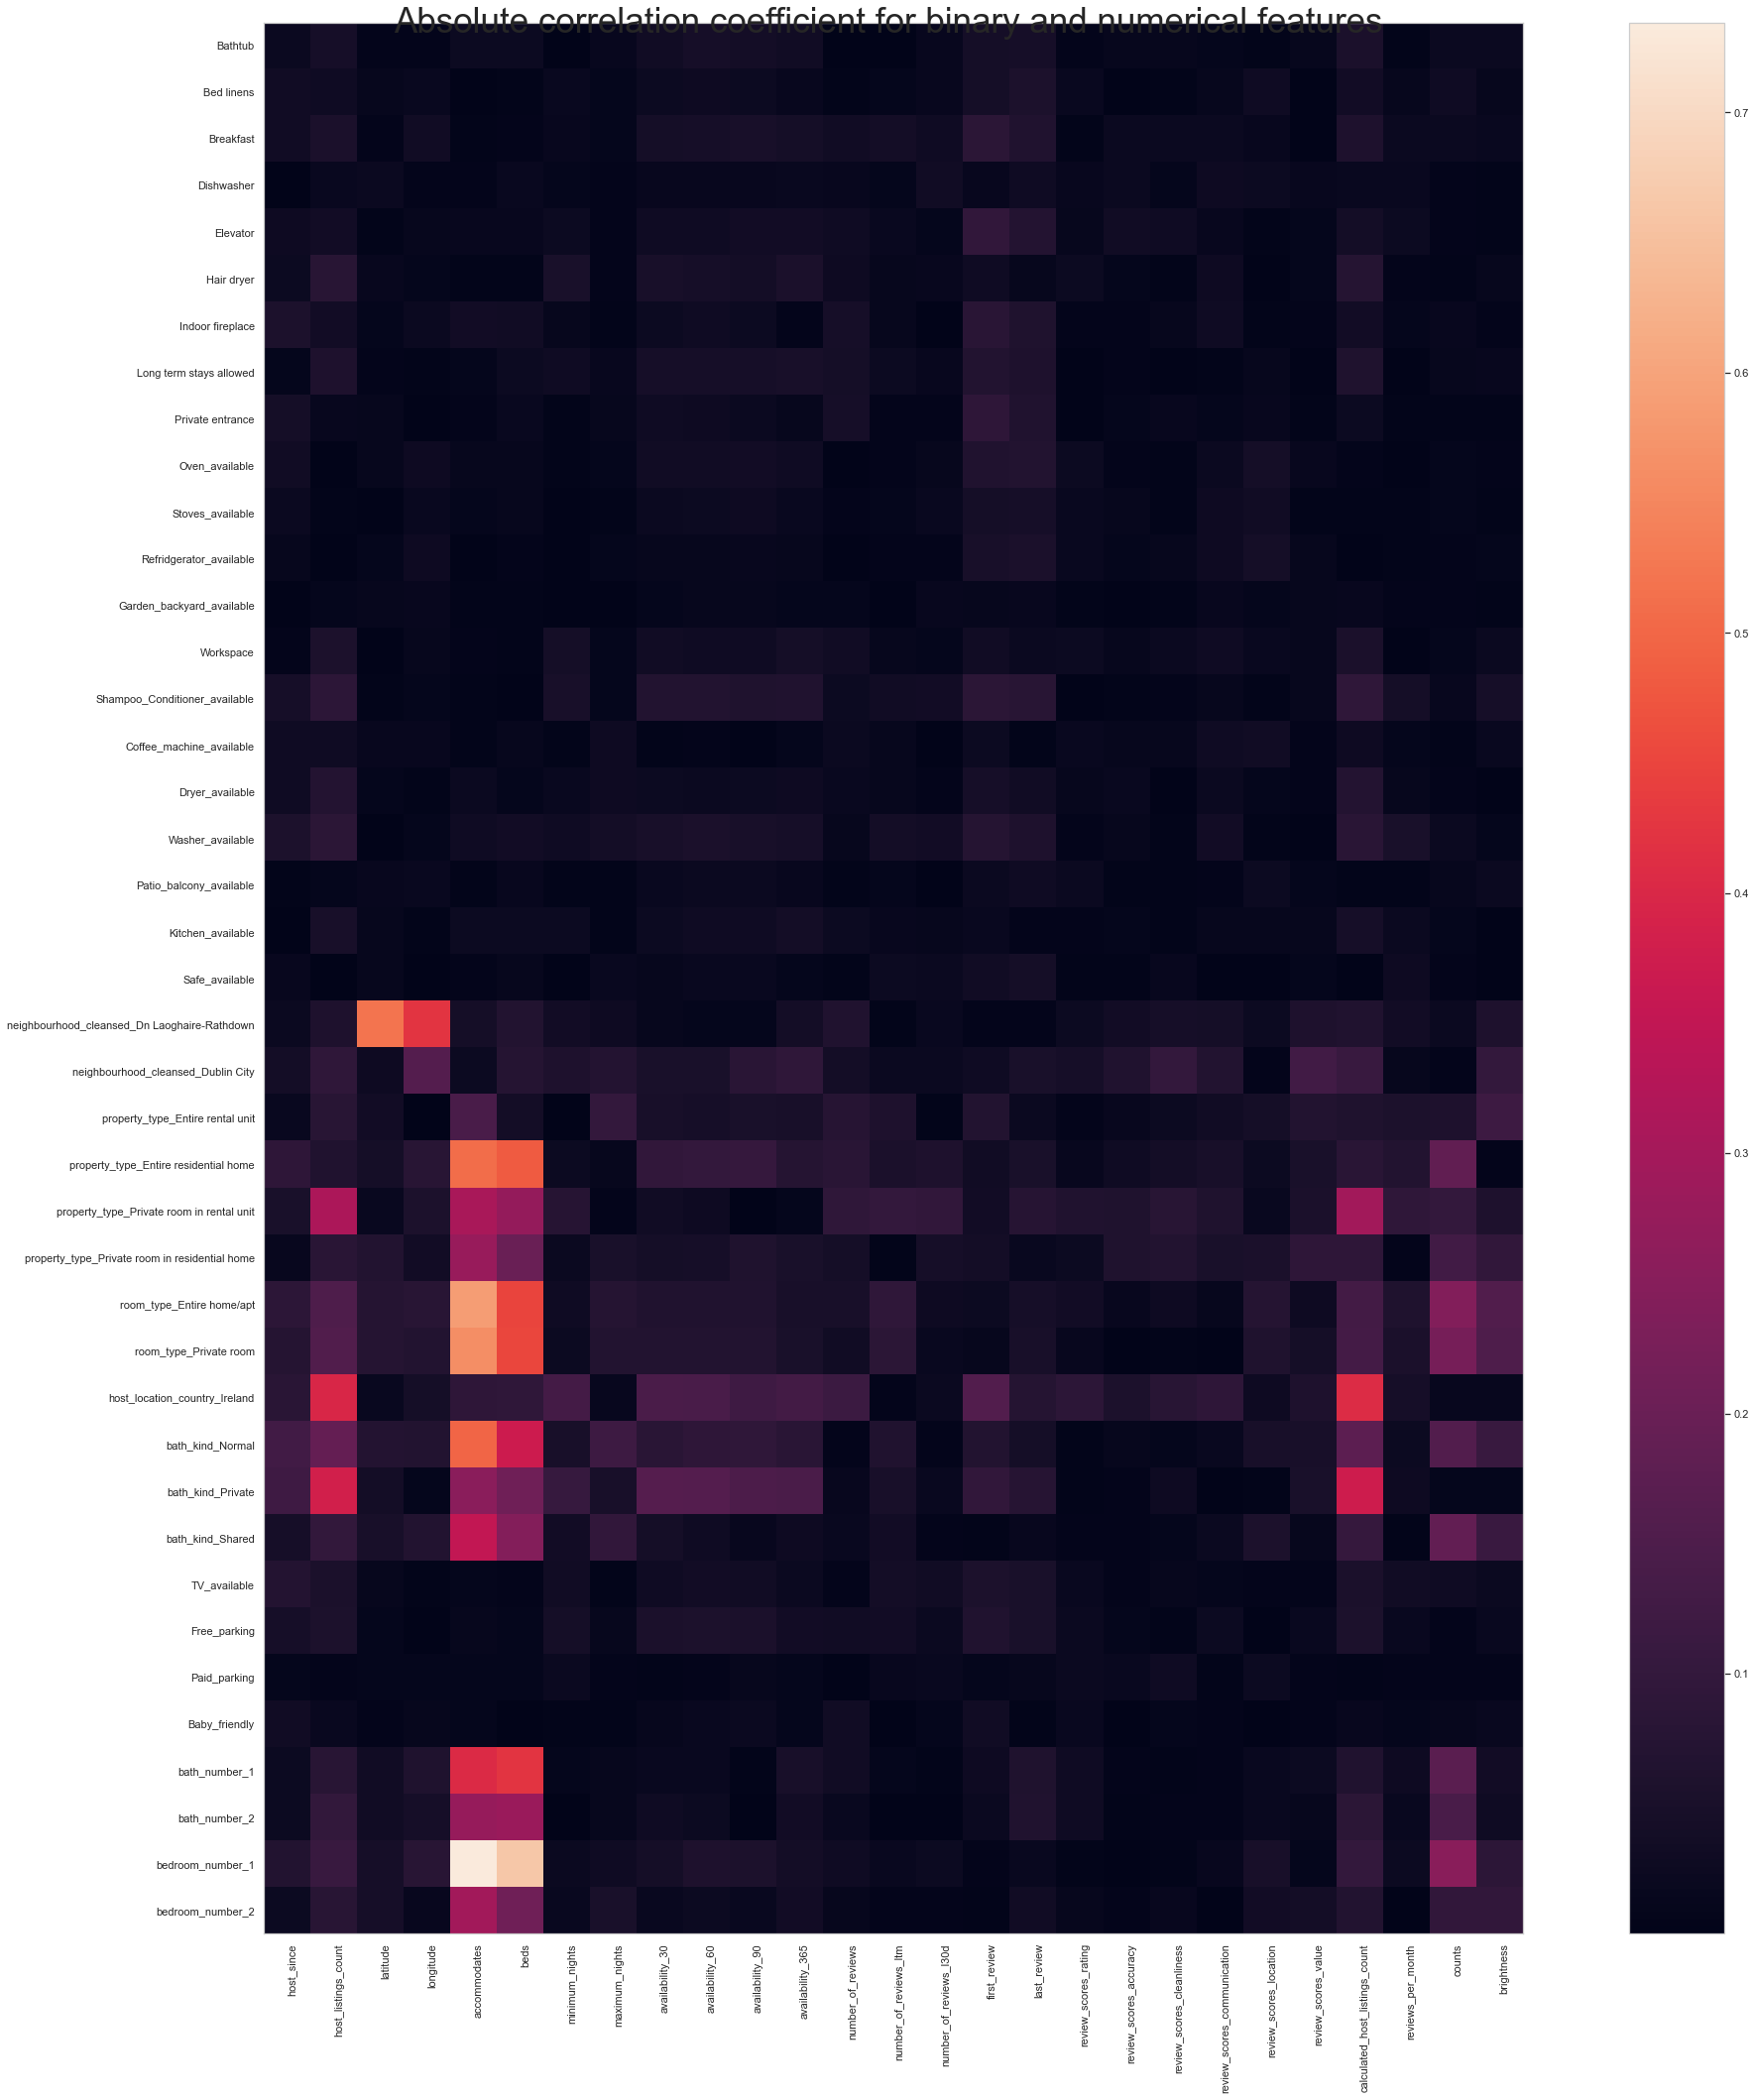

In [144]:
BISERIAL = pd.DataFrame(np.abs(A))
bis_df = pd.DataFrame(np.abs(A))

fig, ax = plt.subplots(figsize = (30,30))
im = ax.imshow(bis_df)
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(numericals.columns)), labels=numericals)
ax.set_yticks(np.arange(len(binaries.columns)), labels=binaries)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.suptitle("Absolute correlation coefficient for binary and numerical features", fontsize = 35)
fig.tight_layout()
plt.show()

## Combine all correlation coefficients in a single matrix

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_31964/2021638428.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(im)


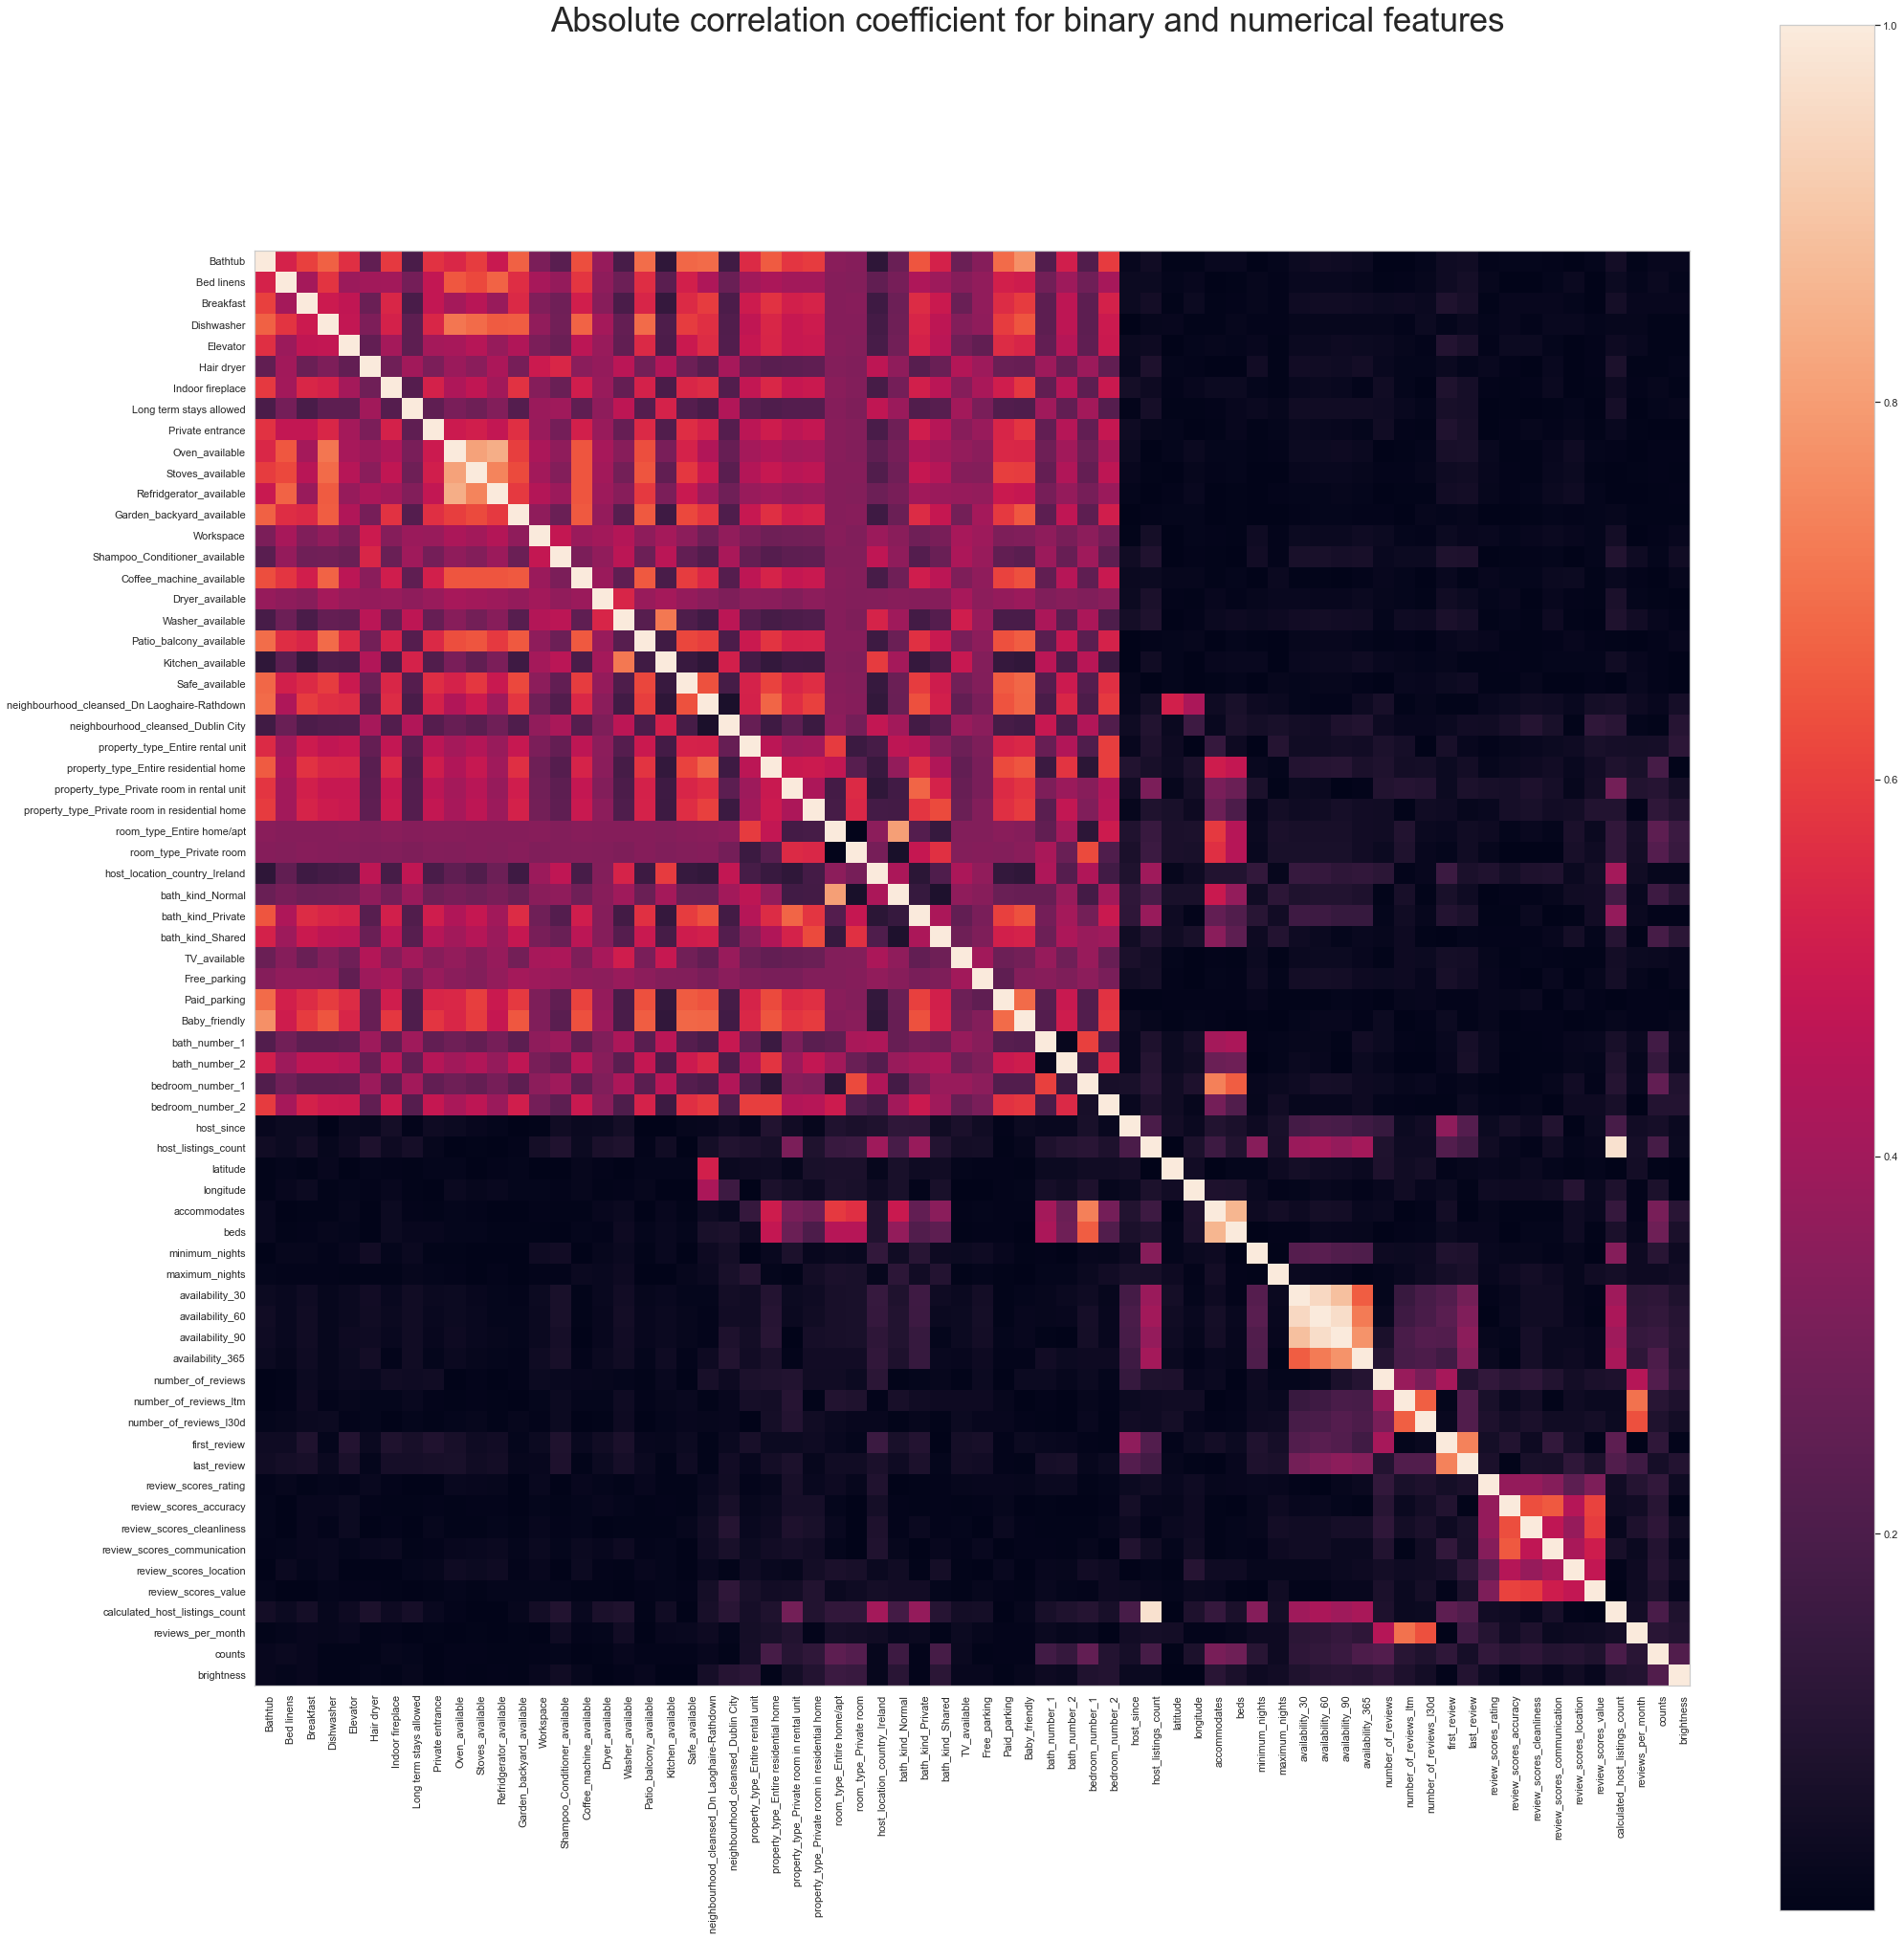

In [145]:
all_col = list(binary_col) + list(num_col)
listings_compl = listings.filter(all_col)
C = np.zeros((len(all_col), len(all_col)))

C[:len(binary_col),:len(binary_col)] = JACCARD
C[len(binary_col):,len(binary_col):] = PEARSON
C[len(binary_col):,:len(binary_col)] = BISERIAL.T
C[:len(binary_col),len(binary_col):] = BISERIAL

C_df = pd.DataFrame(np.abs(C))

fig, ax = plt.subplots(figsize = (30,30))
im = ax.imshow(C_df)
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(C_df.columns)), labels=all_col)
ax.set_yticks(np.arange(len(C_df.columns)), labels=all_col)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.suptitle("Absolute correlation coefficient for binary and numerical features", fontsize = 35)
fig.tight_layout()
plt.show()

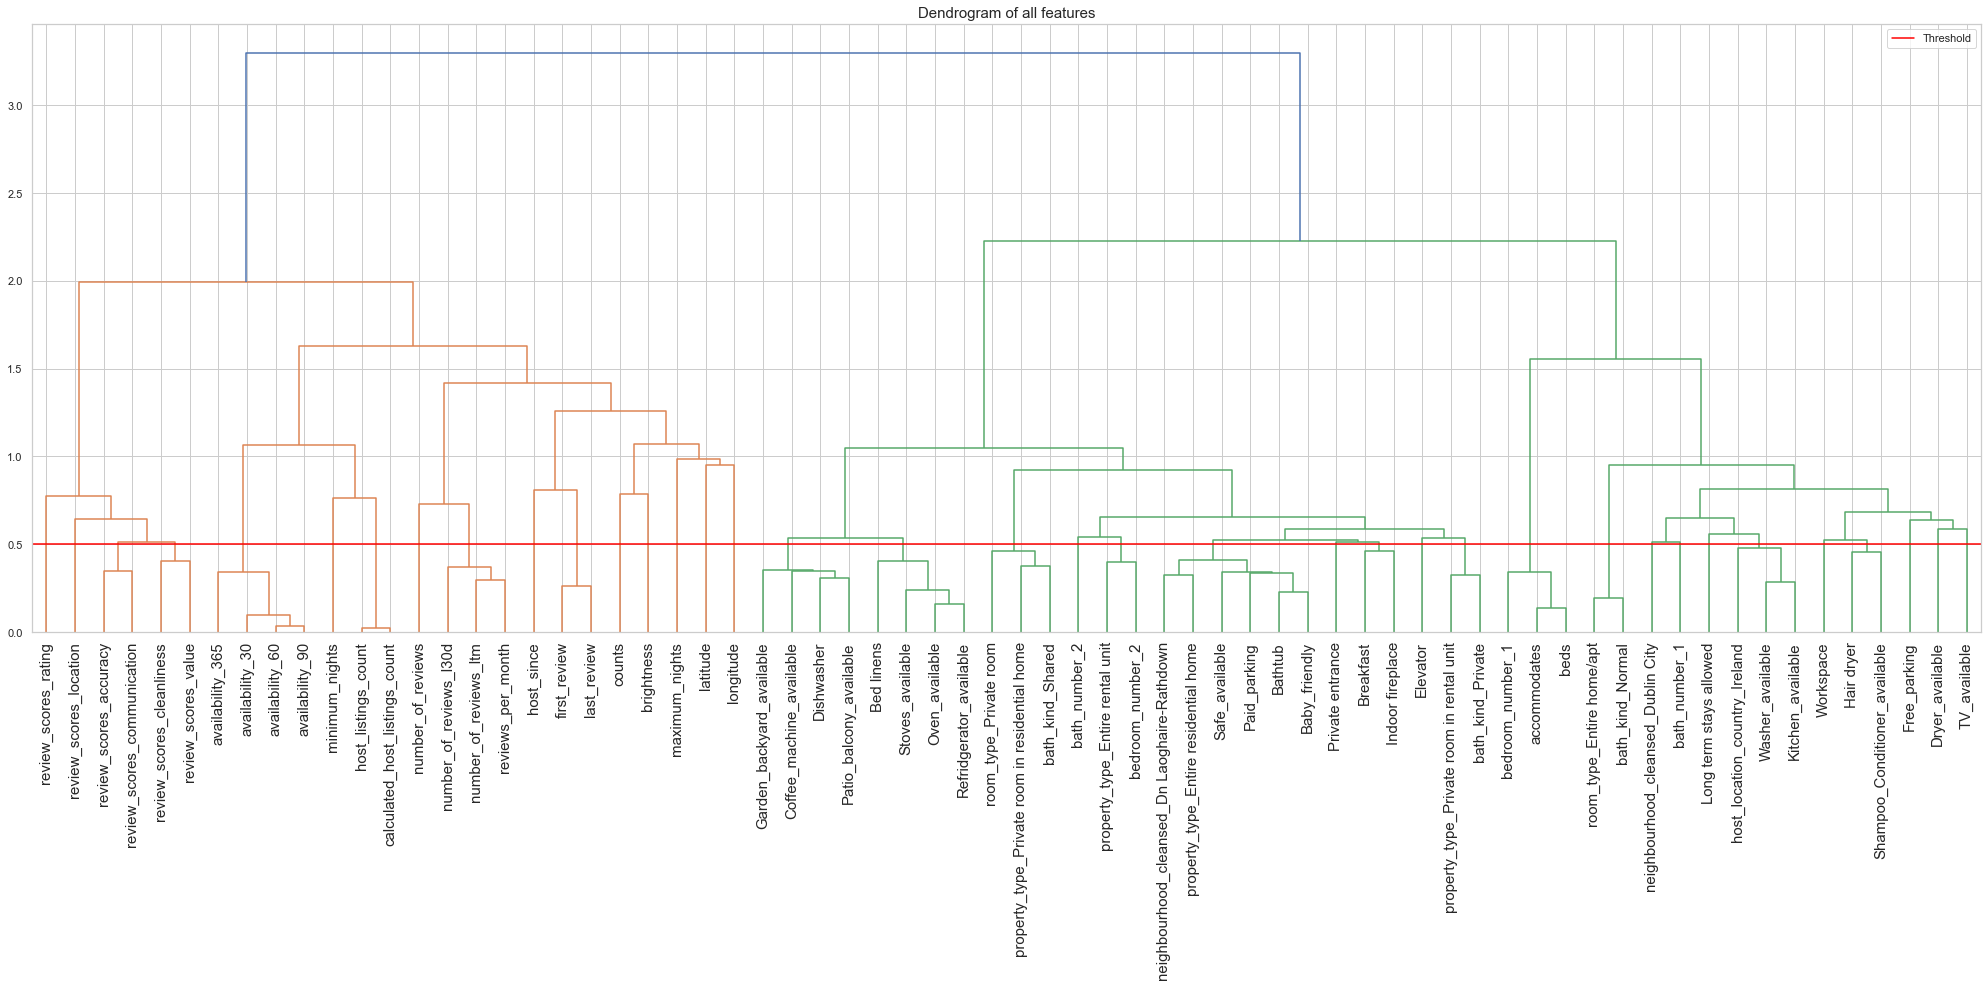

In [146]:

import matplotlib.pyplot as plt
import numpy as np

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

px = 1/plt.rcParams['figure.dpi']
fig, ax = plt.subplots(1, 1, figsize=(2000*px, 1000*px))
corr = C
# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=all_col, ax=ax, leaf_rotation=90, leaf_font_size=15
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title("Dendrogram of all features", fontsize = 15)
ax.axhline(0.5, color = "red", label = "Threshold")
ax.legend()
fig.tight_layout()
plt.show()

The dendrogram shows which features are so similar that it might be reasonable to keep only one of those variables. We can set our threshold around 0.5 and explore the clusters we find below:

### For threshold = 0.5
1. keep room type Entire home/apt
3. keep kitchen available
4. combine to bathroom essentials 
5. combine stove, oven and refridgerator to large kitchen appliances
6. combine patio balcony and garden to outside areas
7. keep room type private room 
8. keep breakfast 
9. keep property type private room in rental unit
10. keep property type entire residential home


In [147]:
listings_compl = drop_col(listings_compl, ["host_location_country_Ireland", "Washer_available", "Bed linens", "Dishwasher", "Coffee_machine_available", 
    "property_type_Private room in residential home", "bath_kind_Shared", "Indoor fireplace", "bath_kind_Private", "Safe_available", 
    "Bathtub", "neighbourhood_cleansed_Dn Laoghaire-Rathdown", "bath_kind_Normal", "bedroom_number_1", "bedroom_number_2", "beds","review_scores_accuracy", "review_scores_value", "review_scores_cleanliness",
    "review_scores_communication","host_listings_count", "availability_30", "availability_60", "availability_90", "number_of_reviews_l30d", "number_of_reviews_ltm", "first_review"], regex = False)
listings_compl = in_one(listings_compl, "(Shampoo_Conditioner)|(Hair dryer)", "bathroom_essentials", regex = True, sum = True, drop = True)
listings_compl = in_one(listings_compl, "(stoves_)|(oven_)|(refridgerator)", "large_kitchen_appliances", regex = True, sum = True, drop = True)
listings_compl = in_one(listings_compl, "(patio_balcony)|(garden_)", "outside_area_available", regex = True, sum = True, drop = True)

/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/helpers.py:9: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  col_filter = df.columns.str.contains(in_cat, case = False, regex = True)


# Final Selection

## Random Forest Model

In [148]:
len(price_y) == len(listings)

True

In [149]:
# train full random forest
forest = RandomForestRegressor(1000, random_state = 123, max_features = "sqrt", max_depth = 7)
X_train, X_test, y_train, y_test = train_test_split(listings_compl, price_y, random_state = 123, test_size = 0.2)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.41189108375897887

## Naive approach with training data

Compute the importance of each feature which is basically the average contribution to the decrease in impurity/MSE. Let's also consider the standard deviation of this contribution.

In [38]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=listings_compl.columns)

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_31964/1908474449.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


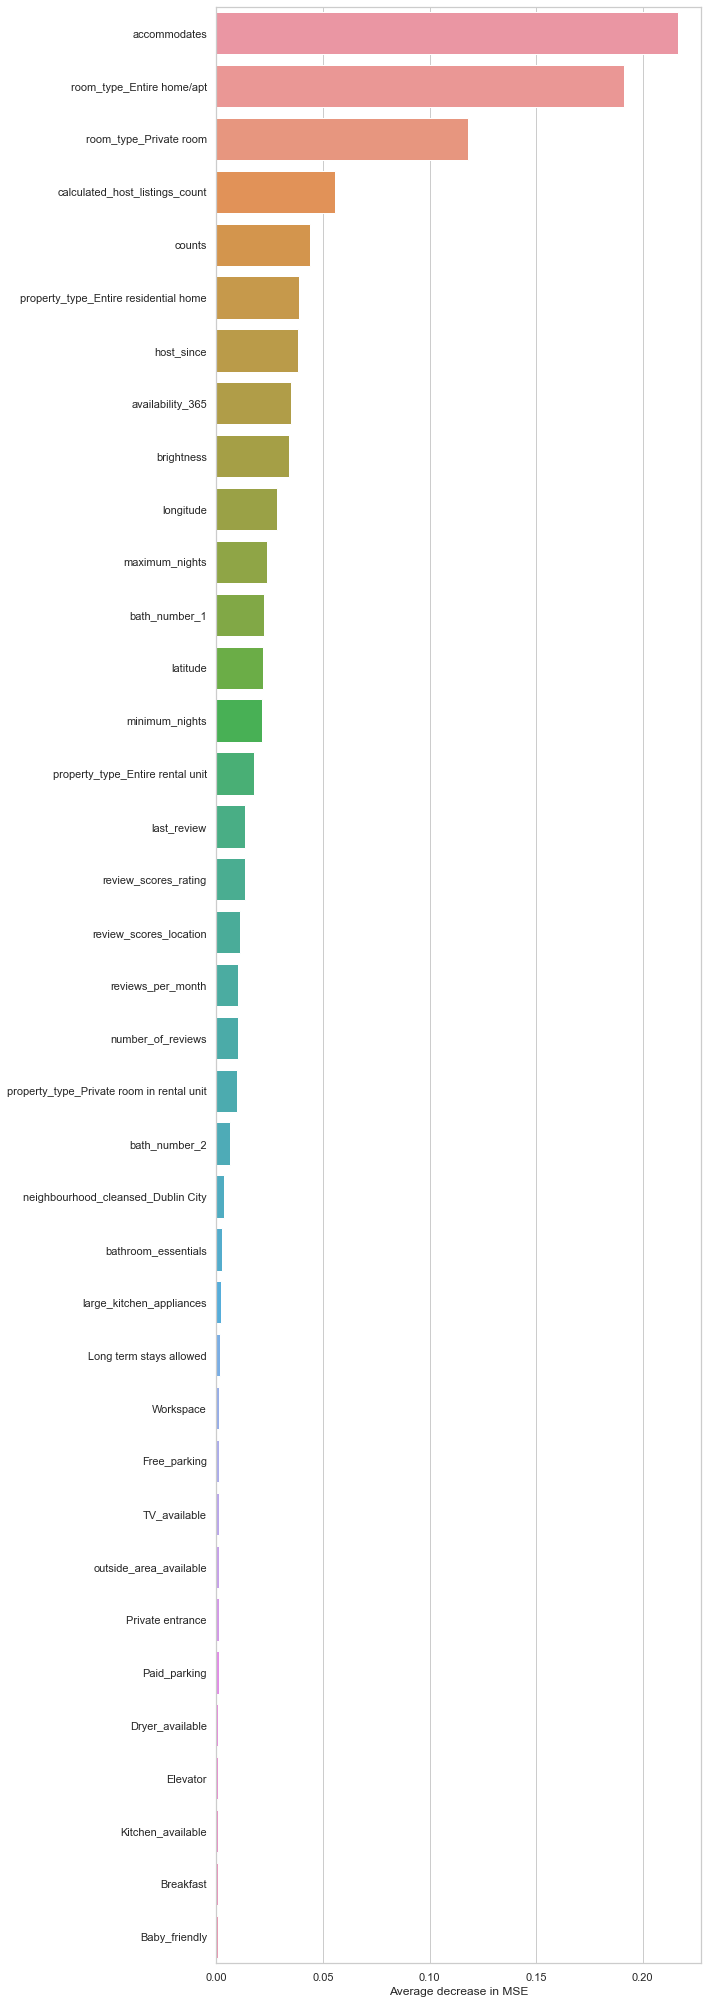

In [39]:
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Average decrease in MSE")
fig.tight_layout()
fig.show()

In [40]:
n_repeats = 10

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_31964/2623107921.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


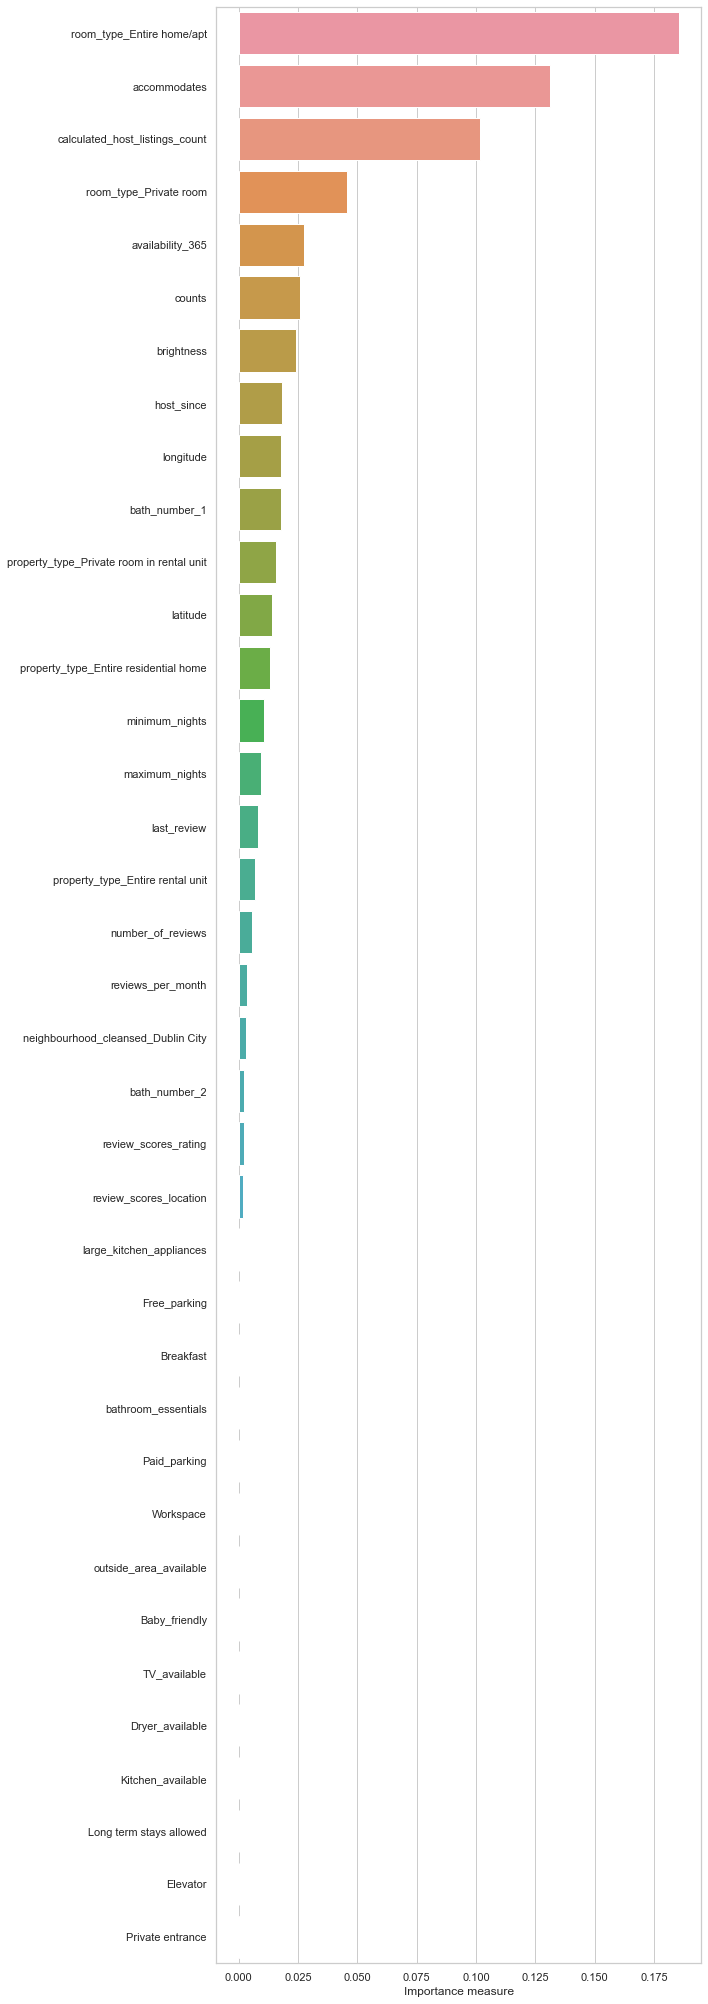

In [41]:
result = permutation_importance(forest, X_test, y_test, n_repeats = n_repeats, random_state=42)
forest_importances = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## Linear Regression

In [42]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.42430194802727816

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_31964/2182281270.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


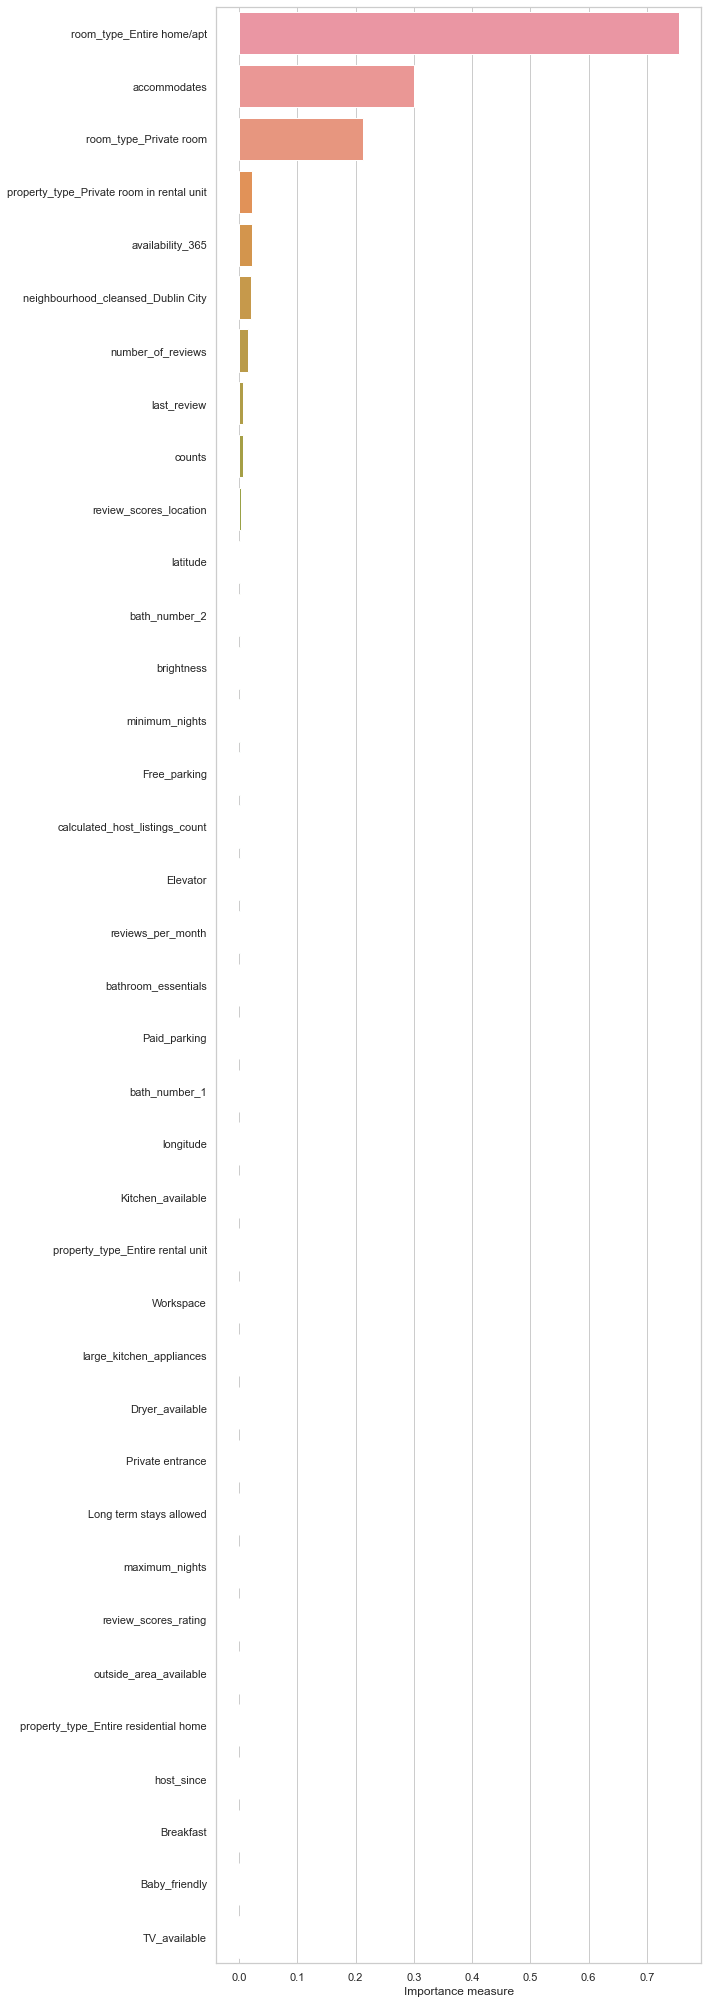

In [43]:
result = permutation_importance(reg, X_test, y_test, n_repeats=n_repeats, random_state=42)
lm_importances = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = lm_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## Ridge with Kernel model
Let's repeat the permutation approach for several other algorithms

### rbf kernel

In [44]:
# train Ridge Kernel model
rbf_ridge = KernelRidge(kernel = "rbf", alpha = 0)
rbf_ridge.fit(X_train, y_train)
rbf_ridge.score(X_test, y_test)

0.10625290263978893

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_31964/2830413365.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


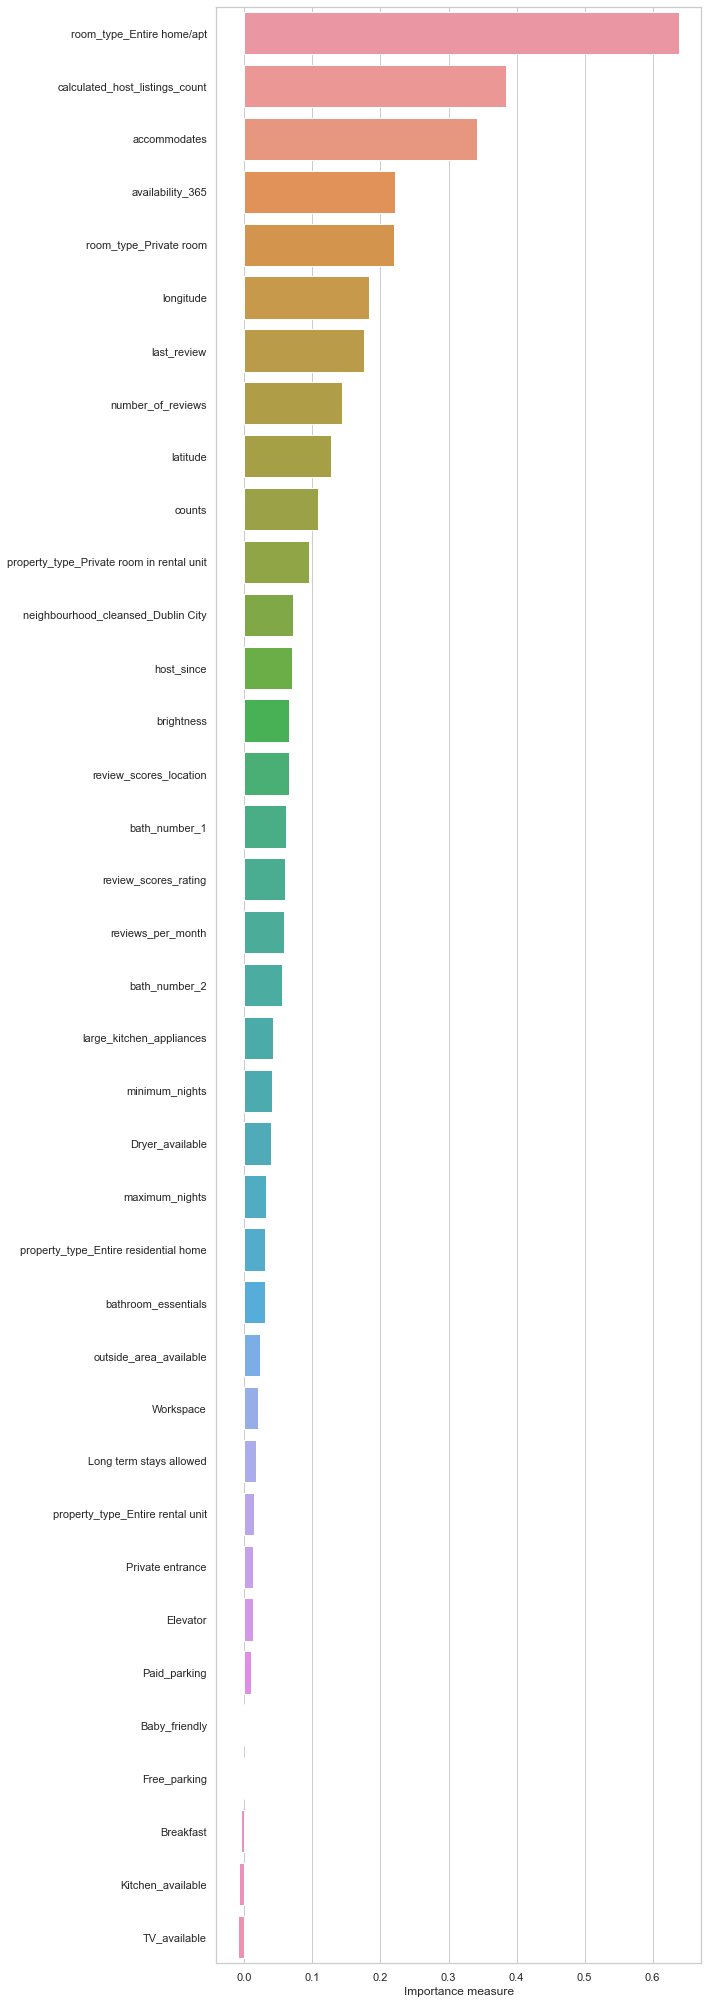

In [45]:
result = permutation_importance(rbf_ridge, X_test, y_test, n_repeats=n_repeats, random_state=42)
rbf_ridge_importances = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = rbf_ridge_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

### linear kernel

In [46]:
# train Ridge Kernel model
linear_ridge = KernelRidge(kernel = "linear")
linear_ridge.fit(X_train, y_train)
linear_ridge.score(X_test, y_test)

0.14460025795973486

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_31964/4222484363.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


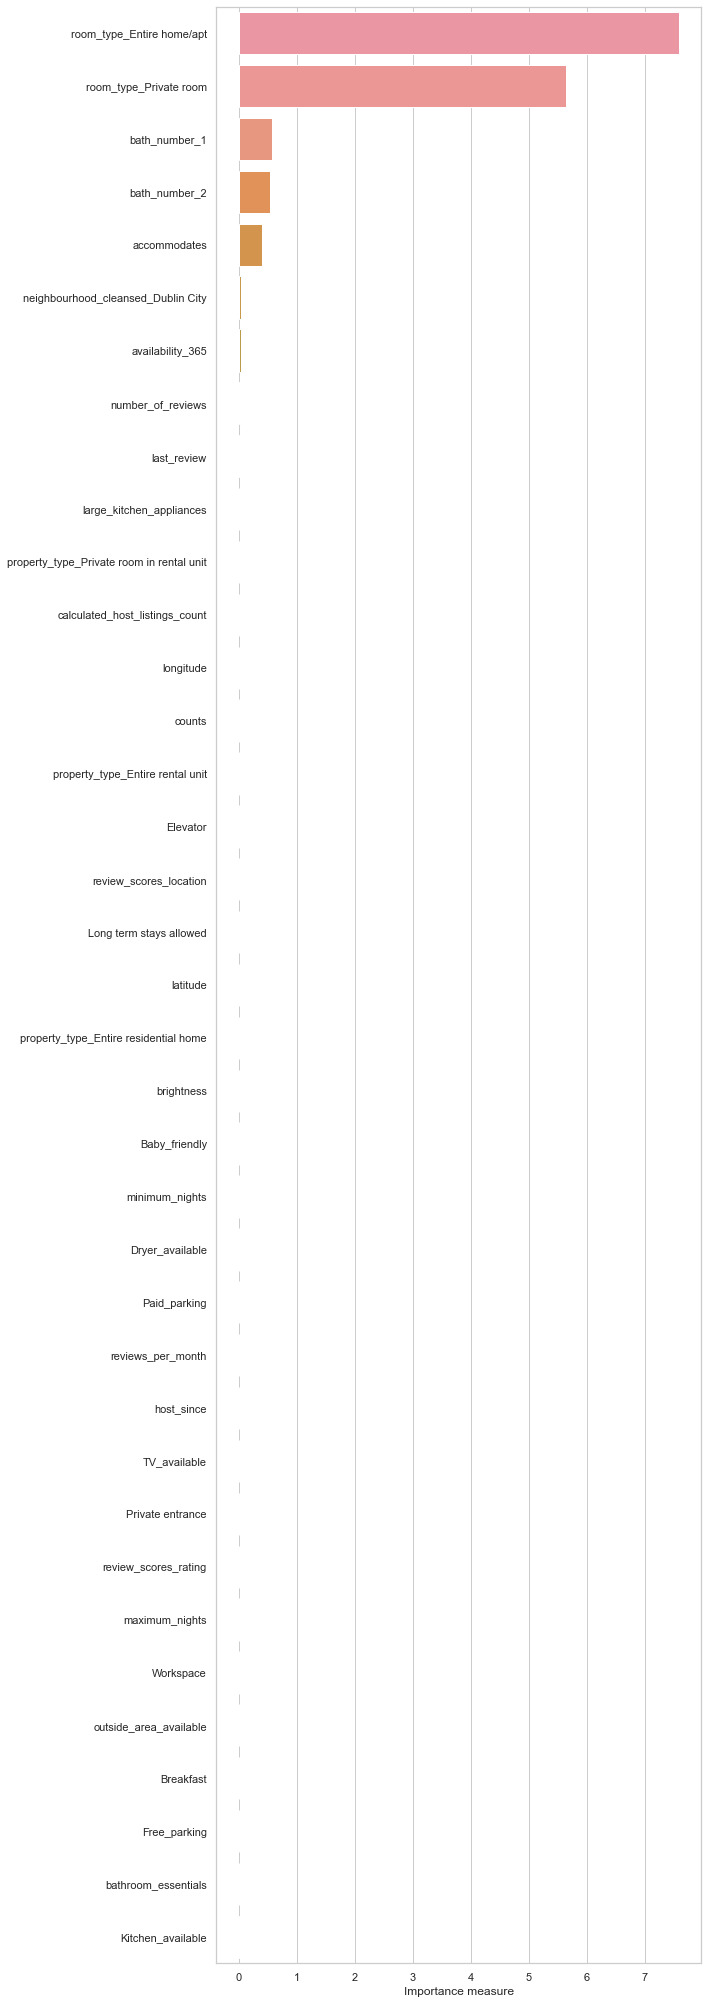

In [47]:
result = permutation_importance(linear_ridge, X_test, y_test, n_repeats=n_repeats, random_state=42)
linear_ridge_importances = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = linear_ridge_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## Boosting

In [64]:
params = {
    "n_estimators": 300,
    "max_depth": 3,
    "min_samples_split": 15,
    "learning_rate": 0.1,
    "loss": "squared_error",
}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.650058398226391

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_31964/1496711808.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


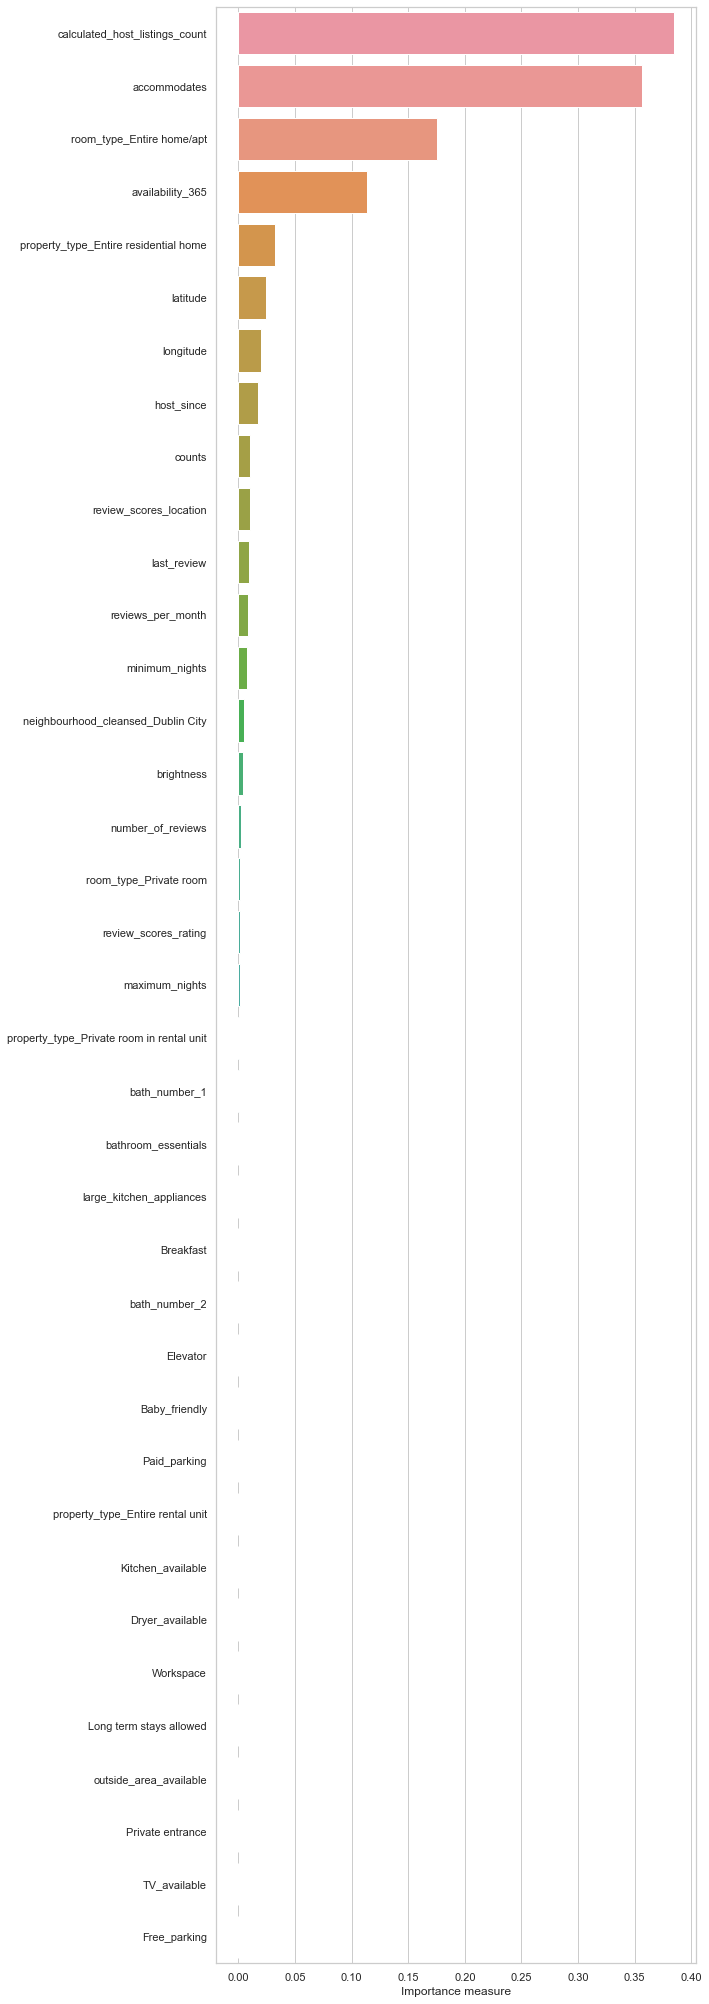

In [49]:
result = permutation_importance(reg, X_test, y_test, n_repeats=n_repeats, random_state=42, scoring = "r2")
boost_feature_importance = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = boost_feature_importance.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

In [50]:
importances = pd.DataFrame({"Forest": forest_importances, "Linear Regression": lm_importances, "RBF Ridge": rbf_ridge_importances, "Linear Ridge": linear_ridge_importances, "Boosting": boost_feature_importance})

In [51]:
importances

,Forest,Linear Regression,RBF Ridge,Linear Ridge,Boosting
Breakfast,0.000214,-0.000632,-0.005047,-0.001672,0.000000
Elevator,-0.000014,0.000954,0.012473,0.003535,0.000000
Long term stays allowed,0.000002,0.000034,0.016675,0.002147,0.000000
Private entrance,-0.000064,0.000123,0.012588,-0.000141,-0.000042
Workspace,0.000097,0.000387,0.019490,-0.000496,0.000000
Dryer_available,0.000016,0.000157,0.039495,0.000893,0.000000
Kitchen_available,0.000011,0.000508,-0.007238,-0.007715,0.000000
neighbourhood_cleansed_Dublin City,0.003224,0.020600,0.071658,0.040364,0.004614
property_type_Entire rental unit,0.006932,0.000398,0.014094,0.003548,0.000000
property_type_Entire residential home,0.013301,-0.000250,0.030053,0.001218,0.032617


In [52]:
importances.mean(axis = 1).sort_values(ascending=False)

room_type_Entire home/apt                    1.870730
room_type_Private room                       1.226021
accommodates                                 0.306098
calculated_host_listings_count               0.175298
bath_number_1                                0.130603
bath_number_2                                0.119965
availability_365                             0.083055
longitude                                    0.045143
last_review                                  0.042295
number_of_reviews                            0.037152
latitude                                     0.033864
counts                                       0.031083
property_type_Private room in rental unit    0.028149
neighbourhood_cleansed_Dublin City           0.028092
host_since                                   0.021118
brightness                                   0.019324
review_scores_location                       0.016940
property_type_Entire residential home        0.015388
reviews_per_month           